# Problem Set 2020

Author: Emma Louise Espersen Knudsen

Course: Applied Statistics: From Data to Results

Year: 2020

run: pip3 install iminuit==1.5.4

Packages and functions used:

In [63]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories
from IPython.core.display import Latex
from math import factorial
from sympy import * 
from scipy import stats
from scipy.stats import linregress
sys.path.append('../External_Functions')
from ExternalFunctions import Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure
from scipy.optimize import curve_fit

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics

figpath = '/home/jovyan/work/AppStat2020_local/ProblemSet/Figures'

def lprint(*args,**kwargs):
    """Pretty print arguments as LaTeX using IPython display system 
    
    Parameters
    ----------
    args : tuple 
        What to print (in LaTeX math mode)
    kwargs : dict 
        optional keywords to pass to `display` 
    """
    display(Latex('$$'+' '.join(args)+'$$'),**kwargs)

## I) Distributions and probabilities

### 1.1) (4 points) Assuming the “El Clasico” football match is an even game $(p = 0.5)$, what is the probability, that the score after 144 non-draw league games is exactly even?

This is a binomial distribution, as there are $n=144$ identical games each with the same probability $p=0.5$ of a certain outcome. The probability is thus given by:

$$P(x)=\frac{n!}{x!(n-x)!}p^xq^{n-x}$$

where $q=1-p$.

If the score is exactly even after the $144$ identical games, then each of the two teams each win $144/2=72$ times, so $x=72$.

In [2]:
n = 144
x = 72
p = 0.5
q = 1-p

prob = (factorial(n) / (factorial(x) * factorial(n-x))) * p**x * q**(n-x)

print('P(x=72) =',prob*100,'%')

P(x=72) = 6.63750464511973 %


### 1.2) (4 points) Brad Pitt and Edward Norton are shooting golf balls at a window with $p_{hit} = 0.054$ chance of hitting. How many golf balls do they need to be $90\%$ sure of hitting the window?

The probability of no successes given $p=0.054$ is given by $(1-p_{\rm hit})^n$, we can thus say:

$$1-0.9=(1-p)^n$$

and solve for $n$. This yields:

$$n=\frac{\ln(1-0.1)}{\ln(1-p_{\rm hit})}=41.5\approx 42$$

So they need to shoot the ball at least 42 times.

## II) Error propagation

### 2.1) (10 points) The Hubble constant $h$ has been measured by seven independent experiments: $73.5\pm 1.4$, $74.0 \pm 1.4$, $73.3 \pm 1.8$, $75.0 \pm 2.0$, $67.6 \pm 0.7$, $70.4 \pm 1.4$, and $67.66 \pm 0.42$ in (km/s)/Mpc.

#### A) What is the weighted average of $h$? Do the values agree with each other?

The weighted average can be found using the formula (Barlow, p. 83):
$$\hat{\mu}=\frac{\sum_{i=1}^n\left(\frac{x_i}{\sigma_i^2}\right)}{\sum_{i=1}^n\frac{1}{\sigma_i^2}}$$
and the standard error of the weighted average (with variance weights) is:
$$\sigma_{\hat{\mu}}=\sqrt{\frac{1}{\sum_{i=1}^n\sigma_i^{-2}}}$$
Doing the calculations, we arrive at a weighted average with sandard error of:

In [3]:
h_val  = np.array([73.5,74.0,73.3,75.0,67.6,70.4,67.66])
h_err  = np.array([1.4,1.4,1.8,2.0,0.7,1.4,0.42])
ones   = np.array([1,2,3,4,5,6,7])
mu_w   = np.sum(h_val/h_err**2)/np.sum(1/h_err**2)
mu_s   = np.sqrt(1/(np.sum(h_err**(-2))))

lprint(latex(Eq(symbols('\hat{\mu}'),np.round(mu_w,1))),'\,(km/s)/Mpc')
lprint(latex(Eq(symbols('\sigma_{\hat{\mu}}'),np.round(mu_s,1))),'\,(km/s)/Mpc')


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

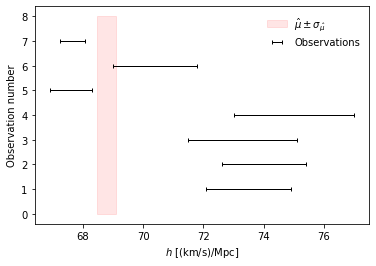

In [4]:
plt.errorbar(h_val, ones, yerr=None, xerr=h_err, ecolor='black', elinewidth=1, capsize=2,linestyle='None',label='Observations');
plt.fill_betweenx([0,8], mu_w-mu_s, mu_w+mu_s, alpha=0.1, color='red',label=r'$\hat{\mu}\pm\sigma_{\hat{\mu}}$');
plt.xlabel(r'$h$ [(km/s)/Mpc]')
plt.ylabel('Observation number')
plt.legend(frameon=False);


We thus see that only one value falls within the weighted average and its standard deviation, while the four values on the right agree with each other and the two values of the left agree with each other.

#### B) The first four measurements (Group A) are based on a different method than the last three (Group B). Do the values from the same method agree with each other?

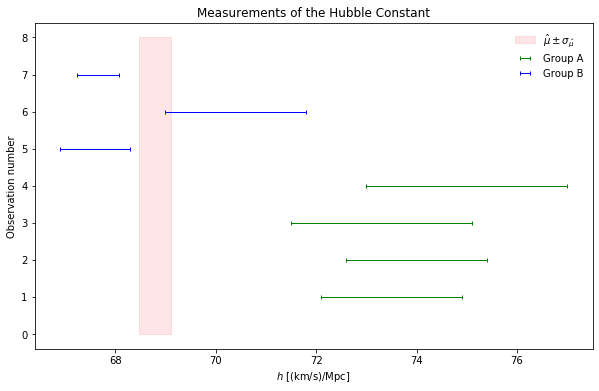

In [5]:
fig = plt.figure(figsize=(10,6))

plt.errorbar(h_val[:4], ones[:4], yerr=None, xerr=h_err[:4], ecolor='green', elinewidth=1, capsize=2,linestyle='None',label='Group A');
plt.errorbar(h_val[4:], ones[4:], yerr=None, xerr=h_err[4:], ecolor='blue', elinewidth=1, capsize=2,linestyle='None',label='Group B');
plt.fill_betweenx([0,8], mu_w-mu_s, mu_w+mu_s, alpha=0.1, color='red',label=r'$\hat{\mu}\pm\sigma_{\hat{\mu}}$');

plt.title('Measurements of the Hubble Constant')
plt.xlabel(r'$h$ [(km/s)/Mpc]')
plt.ylabel('Observation number')
plt.legend(frameon=False)

fig.savefig('{0}/{1}.pdf'.format(figpath,'opg_2_1_B'), bbox_inches="tight")

We see that for Group A, All measurements agree with each other. For group B, only observation number 5 and 7 agree.

### 2.2) (10 points) Using Coulomb’s law you want to measure a charge, $q_0 = F d^2/k_eQ$. Assume that Coulomb’s constant $k_e = 8.99\times 10^9$ Nm$^2$/C$^2$ and the instrument charge $Q = 10^{−9}$ C are known.
#### A) Given force $F = 0.87 \pm 0.08$ N and distance $d = 0.0045 \pm 0.0003$ m, what is $q_0$?

In [6]:
# Define variables:
q0,F,d,ke,Q = symbols("q_0, F, d, k_e, Q")
dq0,dF,dd = symbols("sigma_{q_0}, sigma_F, sigma_d")

# Define relation, and print:
q0 = F*d**2/(ke*Q)
lprint(latex(Eq(symbols('q_0'),q0)))

# Calculate uncertainty and print:
dq0 = sqrt((q0.diff(F) * dF)**2 + (q0.diff(d) * dd)**2)
lprint(latex(Eq(symbols('\sigma_{q_0}'), dq0)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [7]:
# Define parameters
F   = 0.87
dF  = 0.08
d   = 0.0045
dd  = 0.0003
ke  = 8.99*1e9
Q   = 1e-9

q0  = F*d**2/(ke*Q)
dq0 = np.sqrt(((4*F**2*d**2*dd**2)/(Q**2*ke**2))+((d**4*dF**2)/(Q**2*ke**2)))

# Print values
print('q0 = (',np.round(q0*1e6,1),'+/-',np.round(dq0*1e6,1),') x 1e6 [C]')

q0 = ( 2.0 +/- 0.3 ) x 1e6 [C]


#### B) Where does the largest contribution to the uncertainty on $q_0$ come from? $F$ or $d$?

We can check this explicitly:
$$\left(\frac{\text{d}q_0}{\text{d}F}\right)^2\sigma_F^2=\frac{d^4\sigma_F^2}{Q^2k_e^2}\approx 3.25\times 10^{-14}\,\text{C}^2,\quad \left(\frac{\text{d}q_0}{\text{d}d}\right)^2\sigma_d^2=\frac{4F^2d^2\sigma_d^2}{Q^2k_e^2}\approx 6.83\times 10^{-14}\,\text{C}^2$$

So the error arising from the distance $d$, that is the term involving $\sigma_d^2$, is the largest contributor to the error.

#### C) If you could measure $F$ and $d$ with uncertainties $\pm 0.01$ N and $\pm 0.0001$ m, respectively, at what distance should you expect to measure the charge in question $q_0$ most precisely?

In [8]:
dF = 0.01
dd = 0.0001
d = np.linspace(0,5*1e-3,100)
q0  = F*d**2/(ke*Q)
dq0 = np.sqrt(((4*F**2*d**2*dd**2)/(Q**2*ke**2))+((d**4*dF**2)/(Q**2*ke**2)))


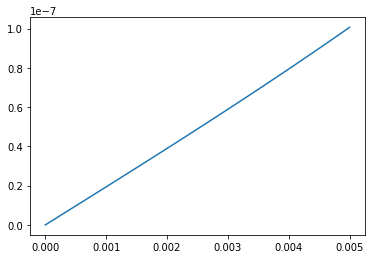

In [9]:
plt.plot(d,dq0)

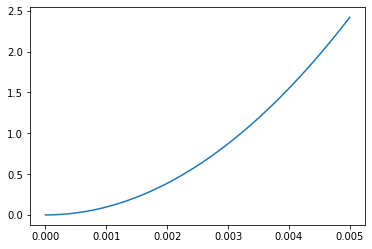

In [10]:
plt.plot(d,q0*1e6)

### 2.3) (12 points) Sub-saharan humans tend not to have any Neanderthal DNA, while all others have a few percent. The file: www.nbi.dk/∼petersen/data_DNAfraction.txt contains the fraction of Neanderthal DNA for 2318 Danish high school students.
#### A) Plot the distribution of Neanderthal DNA fraction, and calculate the mean and RMS.

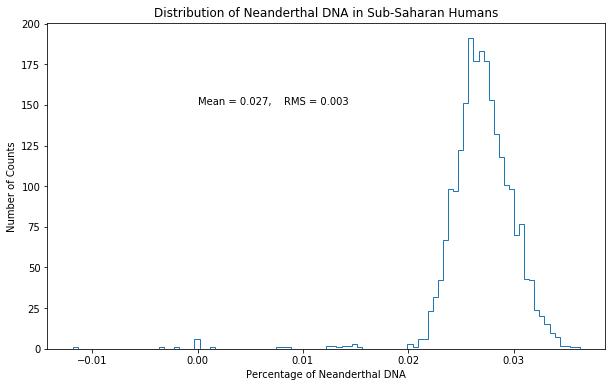

In [11]:
DNAfraction = np.genfromtxt("data_DNAfraction.txt", unpack=True)

dna_sum = np.sum([(DNAfraction.mean()-DNAfraction[i])**2 for i in range(len(DNAfraction))])

rms_dna = np.sqrt((1/len(DNAfraction))*dna_sum)

xmin, xmax = DNAfraction.min(), DNAfraction.max()

fig2, ax2 = plt.subplots(figsize=(10,6));
counts, bin_edges, _ = ax2.hist(DNAfraction, 100, range=(xmin, xmax), histtype='step');
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
s_counts = np.sqrt(counts)

ax2.set_xlabel('Percentage of Neanderthal DNA')
ax2.set_ylabel('Number of Counts')
plt.title('Distribution of Neanderthal DNA in Sub-Saharan Humans')

ax2.text(x=0.0,y=150,s=f"Mean = {DNAfraction.mean():5.3f},    RMS = {rms_dna:5.3f}")

fig2.savefig('{0}/{1}.pdf'.format(figpath,'opg_2_3_A'), bbox_inches="tight")

#### B) Do you find any mismeasurements or outliers from the main population in the data?

Any outliers would be outside $\pm 3\sigma$, so we check this:

In [12]:
sigma_r    = DNAfraction.std(ddof=1)
mean_r     = DNAfraction.mean()
N3_sigma  = 0                           # Counter for the number of produced sums, that fall outside +-3 sigma
N35_sigma  = 0                          # Counter for the number of produced sums, that fall outside +-3.5 sigma
N4_sigma  = 0                           # Counter for the number of produced sums, that fall outside +-4 sigma
N5_sigma  = 0                           # Counter for the number of produced sums, that fall outside +-5 sigma

for entry in DNAfraction:
    if not (mean_r-3*sigma_r < entry < mean_r+3*sigma_r):
        N3_sigma += 1
    if not (mean_r-3.5*sigma_r < entry < mean_r+3.5*sigma_r):
        N35_sigma += 1
    if not (mean_r-4.0*sigma_r < entry < mean_r+4.0*sigma_r):
        N4_sigma += 1
    if not (mean_r-5.0*sigma_r < entry < mean_r+5.0*sigma_r):
        N5_sigma += 1

print('Number of outliers for 3-sigma:',N3_sigma)
print('Number of outliers for 3.5-sigma:',N35_sigma)
print('Number of outliers for 4-sigma:',N4_sigma)
print('Number of outliers for 5-sigma:',N5_sigma)

Number of outliers for 3-sigma: 26
Number of outliers for 3.5-sigma: 25
Number of outliers for 4-sigma: 18
Number of outliers for 5-sigma: 13


In [13]:
clean = np.argwhere((mean_r-3*sigma_r < DNAfraction)& (DNAfraction < mean_r+3*sigma_r))

sigma = DNAfraction[clean].std(ddof=1)
mean  = DNAfraction[clean].mean()

xmin, xmax = DNAfraction[clean].min(), DNAfraction[clean].max()
counts, bin_edges = np.histogram(DNAfraction[clean], 100, range=(xmin, xmax));
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
s_counts = np.sqrt(counts)

#### C) Fit the main population data with distributions of your choice, and comment on the fits.

I will first fit with a Gaussian distribution:

In [14]:
def gaussian(x, N, mu, sigma):
    return N * 1.0 / (sigma*np.sqrt(2*np.pi)) * np.exp(-0.5* (x-mu)**2/sigma**2)

In [15]:
Chi2_object = Chi2Regression(gaussian, bin_centers[counts>0], counts[counts>0], s_counts[counts>0])
minuit = Minuit(Chi2_object, N=len(DNAfraction[clean]), mu=DNAfraction[clean].mean(), sigma=DNAfraction[clean].std(ddof=1), pedantic=False, print_level=0)
minuit.migrad()                          

for name in minuit.parameters:
    print("Fit value: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit.values[name], minuit.errors[name]))

chi2 = minuit.fval
N_var = 3                                # Number of variables (N, mu, sigma)
N_dof = len(counts[counts>0]) - N_var    # Number of degrees of freedom

chi2_prob =  stats.chi2.sf(chi2, N_dof) # The chi2 probability given N_DOF degrees of freedom

Fit value: N = 0.35430 +/- 0.00760
Fit value: mu = 0.02718 +/- 0.00006
Fit value: sigma = 0.00244 +/- 0.00004


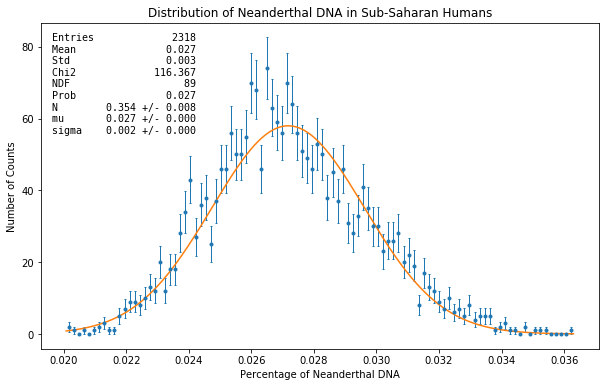

In [16]:
fig2, ax2 = plt.subplots(figsize=(10,6));

ax2.errorbar(bin_centers,counts,yerr=s_counts,xerr=0,color='C0',fmt='.',capthick=1,elinewidth=1,capsize=1,label='Cleaned Data')

xaxis = np.linspace(xmin, xmax, 1000)
yaxis = gaussian(xaxis, *minuit.args)
ax2.plot(xaxis, yaxis,color='C1',label='Gaussian Fit');

d = {'Entries': len(DNAfraction),
     'Mean': DNAfraction.mean(),
     'Std': DNAfraction.std(ddof=1),
     'Chi2': chi2,
     'NDF': N_dof,
     'Prob': chi2_prob, 
     'N': [minuit.values['N'], minuit.errors['N']], 
     'mu': [minuit.values['mu'], minuit.errors['mu']], 
     'sigma': [minuit.values['sigma'], minuit.errors['sigma']],
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.97, text, ax2, fontsize=10);

ax2.set_xlabel('Percentage of Neanderthal DNA')
ax2.set_ylabel('Number of Counts')
plt.title('Distribution of Neanderthal DNA in Sub-Saharan Humans')

fig2.savefig('{0}/{1}.pdf'.format(figpath,'opg_2_3_C'), bbox_inches="tight")

## III) Monte Carlo

### 3.1) (15 points) Assume that the outcome of an experiment can be described by first drawing a random number $x$ from the distribution $f(x) = C(c_1 + x^{c_2} )$ for $x \in [1, 10]$, where $c_1 = 5$ and $c_2 = 2$ and then using this $x$ value to calculate $y = x \exp(−x)$.
#### A) What is the value of $C$? And what is the mean and RMS of $f(x)$?

$C$ is here a normalization constant as $f(x)$ is a distribution. We can thus determine $C$ by integrating $f(x)$ over the interval $x \in [1, 10]$:
$$f(x)=\int_1^{10}C(c_1+x^{c_2})\, {\rm d}x=C\cdot 378=1$$

so $C=1/378$. The mean is found by:

$$\mu=\int_1^{10} x f(x)\,{\rm d}x=\frac{407}{56}\approx 7.268$$

while the RMS can be found by: 

$$RMS=\frac{1}{10-1}\int_1^{10}f(x)^2\, {\rm d}x = \frac{727}{39690}\approx 0.018$$

#### B) What method(s) can be used to produce random numbers according to $f(x)$? Why?

There are two methods I would suggest using:

The accept/reject method. We see from the distribution and the given criteria that it is bound in both $x$ and $f(x)$, and it does therefore not diverge. The accept/reject method is thus applicaple here.

The transformation method. One can produce random numbers according to the distribution of $f(x)$ by this method, as $F(x)=\int f(x)\,{\rm d}x$ has an inverse. 

I will be producing random numbers according to the accept/reject method.

#### C) Produce 5000 random pairs $(x, y)$ and calculate the correlation(s) between the $(x, y)$ values.

In [17]:
def randomvariate(pdf,Npoints=1000,xmin=0,xmax=1):

    r = np.random
    r.seed(42)

    ymin = pdf(xmin)       
    ymax = pdf(xmax)  
    
    x_accept = np.zeros(Npoints)
    N_trial = 0
    
    for i in range(Npoints):

        while True:

            N_trial += 1                    
            x_trial = r.uniform(xmin, xmax)  
            y_trial = r.uniform(ymin, ymax)

            if (y_trial < pdf(x_trial)):
                break

        x_accept[i] = x_trial

    eff = Npoints / N_trial                        
    eff_err = np.sqrt(eff * (1-eff) / N_trial) # binomial

    print(f"Efficiency of accept/reject method is: {eff:.1%} +/- {eff_err:.1%}")  
    
    return x_accept,N_trial

In [18]:
def pdf_f(x):
    c1 = 5
    c2 = 2
    C  = 378
    return C*(c1+x**c2) 

def y_func(x):
    return x*np.exp(-x)

In [19]:
ran_x,n_trials = randomvariate(pdf_f,Npoints=5000,xmin=1,xmax=10)
ran_y          = y_func(ran_x) 

Efficiency of accept/reject method is: 36.5% +/- 0.4%


In [20]:
corr,_ = stats.pearsonr(ran_x,ran_y)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: -0.760


In [21]:
corr,_ = stats.spearmanr(ran_x,ran_y)
print('Spearmans correlation: %.3f' % corr)

Spearmans correlation: -1.000


#### D) Fit the distribution of the produced $x$ values to $f(x)$, with $c_1$ and $c_2$ as free parameters.

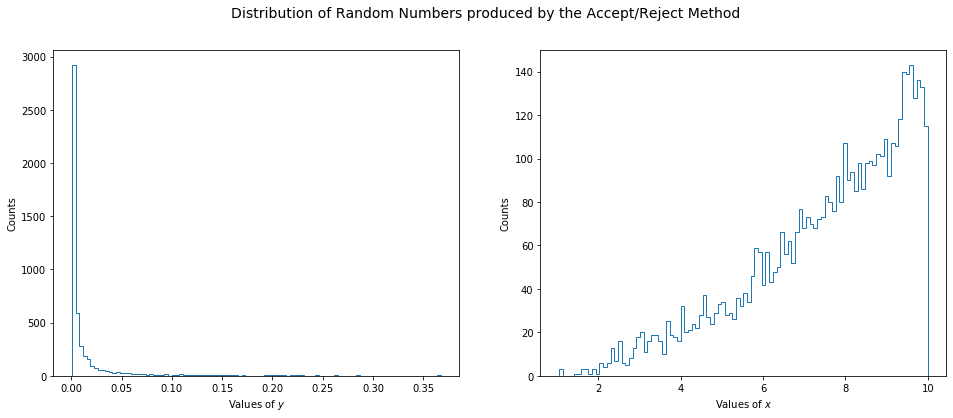

In [22]:
ymin, ymax = ran_y.min(), ran_y.max()
xmin, xmax = ran_x.min(), ran_x.max()

fig, ax = plt.subplots(figsize=(16,6),nrows=1,ncols=2)

ax1 = ax[0]
ax2 = ax[1]

ycounts, ybin_edges, _ = ax1.hist(ran_y, 100, range=(ymin, ymax), histtype='step');
ybin_centers = (ybin_edges[1:] + ybin_edges[:-1])/2
ys_counts = np.sqrt(ycounts)

ax1.set_xlabel(r'Values of $y$')
ax1.set_ylabel('Counts')

xcounts, xbin_edges, _ = ax2.hist(ran_x, 100, range=(xmin, xmax), histtype='step');
xbin_centers = (xbin_edges[1:] + xbin_edges[:-1])/2
xs_counts = np.sqrt(xcounts)

ax2.set_xlabel(r'Values of $x$')
ax2.set_ylabel('Counts')

fig.suptitle('Distribution of Random Numbers produced by the Accept/Reject Method',fontsize=14)


fig.savefig('{0}/{1}.pdf'.format(figpath,'opg_3_1_D'), bbox_inches="tight")

In [23]:
def fit_f(x,c1,c2):
    C = 1/378
    return C*(c1+x**c2) 

In [24]:
xcounts, xbin_edges = np.histogram(ran_x, 100, range=(xmin, xmax))
xbin_widths = xbin_edges[1:] - xbin_edges[:-1]
xbin_centers = (xbin_edges[1:] + xbin_edges[:-1])/2
xs_counts = np.sqrt(xcounts)/ xbin_widths / xcounts.sum()
xcounts = xcounts / xbin_widths / xcounts.sum()

chi2_object = Chi2Regression(fit_f, xbin_centers[xcounts>0], xcounts[xcounts>0],xs_counts[xcounts>0])
minuit = Minuit(chi2_object, print_level=0, pedantic=False, c1=5, c2=2)
minuit.migrad(); 

if (not minuit.fmin.is_valid) :
    print("  WARNING: The ChiSquare fit DID NOT converge!!! ")
    
for name in minuit.parameters:
    print("Fit value: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit.values[name], minuit.errors[name]))
    
chi2_val_fit = minuit.fval
print('Chi2 value of fit:',chi2_val_fit)
Ndata = len(xbin_centers[xcounts>0])
N_DOF = Ndata - len(minuit.args)
print('Degrees of freedom: ',N_DOF)
chi2_prob =  stats.chi2.sf(chi2_val_fit, N_DOF)
print('Chi2 probability',chi2_prob)

d = {'Entries':  Ndata,
     'Chi2':     chi2_val_fit,
     'ndf':      N_DOF,
     'Prob':     chi2_prob,
     'c1':       minuit.values['c1']+-minuit.errors['c1'],
     'c2':    minuit.values['c2']+-minuit.errors['c2']
    }

for name in minuit.parameters:
    d[name] = [minuit.values[name], minuit.errors[name]]
    
d_x = d
chi2_prob_x = chi2_prob
chi2_val_x = chi2_val_fit
args_x = minuit.args

Fit value: c1 = -1.20182 +/- 0.30866
Fit value: c2 = 2.06758 +/- 0.00755
Chi2 value of fit: 106.39352899433743
Degrees of freedom:  95
Chi2 probability 0.19944970572968632


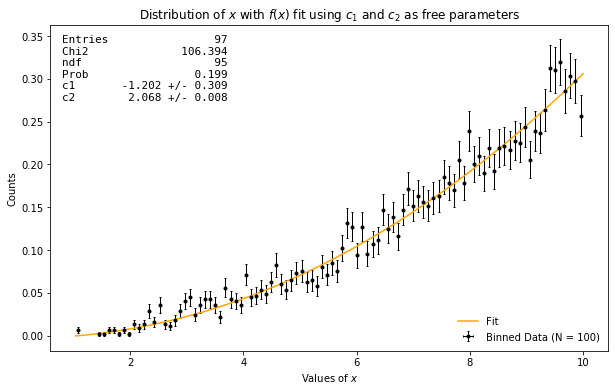

In [25]:
xmin, xmax = ran_x.min(), ran_x.max()
range_x = np.linspace(xmin,xmax,1000)

fig, ax = plt.subplots(figsize=(10,6))

plt.errorbar(xbin_centers[xcounts>0],xcounts[xcounts>0],yerr=xs_counts[xcounts>0],xerr=0,capsize=1,elinewidth=1,capthick=1,linestyle='',fmt='.',label='Binned Data (N = 100)',color='k')
#ax.hist(ran_x, 100, range=(xmin, xmax),density=True,histtype='step',color='k',label='Binned Data (N = 100)');

ax.plot(range_x,fit_f(range_x,*args_x),linestyle='-',color='orange',label='Fit')

ax.set_xlabel(r'Values of $x$')
ax.set_ylabel('Counts')

text = nice_string_output(d_x, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.97, text, ax, fontsize=11);

plt.title(r'Distribution of $x$ with $f(x)$ fit using $c_1$ and $c_2$ as free parameters')
plt.legend(frameon=False,loc='lower right')

fig.savefig('{0}/{1}.pdf'.format(figpath,'opg_3_1_D_fit'), bbox_inches="tight")

#### E) How many measurements of $x$ would you need, in order to determine $c_1$ and $c_2$, respectively, with a precision better than $1\%$ of their values?

In [ ]:
N_pairs = 100

ran_x,n_trials = randomvariate(pdf_f,Npoints=N_pairs,xmin=1,xmax=10)
xmin, xmax = ran_x.min(), ran_x.max()
xcounts, xbin_edges = np.histogram(ran_x, 10, range=(xmin, xmax))

xbin_widths = xbin_edges[1:] - xbin_edges[:-1]
xbin_centers = (xbin_edges[1:] + xbin_edges[:-1])/2

xs_counts = np.sqrt(xcounts)/ xbin_widths / xcounts.sum()
xcounts = xcounts / xbin_widths / xcounts.sum()

xbin_centers=xbin_centers[xcounts>0]
xs_counts=xs_counts[xcounts>0]
xcounts=xcounts[xcounts>0]

chi2_object = Chi2Regression(fit_f, xbin_centers, xcounts, xs_counts)
minuit = Minuit(chi2_object, print_level=0, pedantic=False, c1=5, c2=2)
minuit.migrad(); 
    
chi2_val_fit = minuit.fval
Ndata = len(xbin_centers)
N_DOF = Ndata - len(minuit.args)
chi2_prob =  stats.chi2.sf(chi2_val_fit, N_DOF)

c1_val = minuit.values['c1']
c1_err = minuit.errors['c1']

c1_ratio = c1_val/100

while True:
    
    if c1_err>c1_ratio:

        ran_x,n_trials = randomvariate(pdf_f,Npoints=N_pairs,xmin=1,xmax=10)
        xmin, xmax = ran_x.min(), ran_x.max()
        xcounts, xbin_edges = np.histogram(ran_x, 100, range=(xmin, xmax))
        
        xbin_widths = xbin_edges[1:] - xbin_edges[:-1]
        xbin_centers = (xbin_edges[1:] + xbin_edges[:-1])/2
        xs_counts = np.sqrt(xcounts)/ xbin_widths / xcounts.sum()
        xcounts = xcounts / xbin_widths / xcounts.sum()
        
        xbin_centers=xbin_centers[xcounts>0]
        xs_counts=xs_counts[xcounts>0]
        xcounts=xcounts[xcounts>0]

        chi2_object = Chi2Regression(fit_f, xbin_centers, xcounts, xs_counts)
        minuit = Minuit(chi2_object, print_level=0, pedantic=False, c1=5, c2=2)
        minuit.migrad(); 

        if minuit.fmin.is_valid:

            c1_val = minuit.values['c1']
            c1_err = minuit.errors['c1']

            c1_ratio = c1_val/100

            N_pairs += 10

        elif (not minuit.fmin.is_valid):

            N_pairs +=10
            
    if c1_err<c1_ratio:
        break

N_c1 = N_pairs

In [ ]:
print('Number of runs',N_c1)
print('c1_val/100',c1_ratio)
print('c1_val',c1_val)
print('c1_err',c1_err)

In [ ]:
N_pairs = 10

ran_x,n_trials = randomvariate(pdf_f,Npoints=N_pairs,xmin=1,xmax=10)
xmin, xmax = ran_x.min(), ran_x.max()
xcounts, xbin_edges = np.histogram(ran_x, 10, range=(xmin, xmax))

xbin_widths = xbin_edges[1:] - xbin_edges[:-1]
xbin_centers = (xbin_edges[1:] + xbin_edges[:-1])/2
xs_counts = np.sqrt(xcounts)/ xbin_widths / xcounts.sum()
xcounts = xcounts / xbin_widths / xcounts.sum()

xbin_centers=xbin_centers[xcounts>0]
xs_counts=xs_counts[xcounts>0]
xcounts=xcounts[xcounts>0]

chi2_object = Chi2Regression(fit_f, xbin_centers, xcounts, xs_counts)
minuit = Minuit(chi2_object, print_level=0, pedantic=False, c1=5, c2=2)
minuit.migrad(); 
    
chi2_val_fit = minuit.fval
Ndata = len(xbin_centers)
N_DOF = Ndata - len(minuit.args)
chi2_prob =  stats.chi2.sf(chi2_val_fit, N_DOF)

c2_val = minuit.values['c2']
c2_err = minuit.errors['c2']

c2_ratio = c2_val/100

while True:
    
    if c2_err>c2_ratio:

        ran_x,n_trials = randomvariate(pdf_f,Npoints=N_pairs,xmin=1,xmax=10)
        xmin, xmax = ran_x.min(), ran_x.max()
        xcounts, xbin_edges = np.histogram(ran_x, 100, range=(xmin, xmax))
        
        xbin_widths = xbin_edges[1:] - xbin_edges[:-1]
        xbin_centers = (xbin_edges[1:] + xbin_edges[:-1])/2
        xs_counts = np.sqrt(xcounts)/ xbin_widths / xcounts.sum()
        xcounts = xcounts / xbin_widths / xcounts.sum()
        
        xbin_centers=xbin_centers[xcounts>0]
        xs_counts=xs_counts[xcounts>0]
        xcounts=xcounts[xcounts>0]

        chi2_object = Chi2Regression(fit_f, xbin_centers, xcounts, xs_counts)
        minuit = Minuit(chi2_object, print_level=0, pedantic=False, c1=5, c2=2)
        minuit.migrad(); 

        if minuit.fmin.is_valid:

            c2_val = minuit.values['c2']
            c2_err = minuit.errors['c2']

            c2_ratio = c2_val/100

            N_pairs += 10

        elif (not minuit.fmin.is_valid):

            N_pairs +=10
            
    if c2_err<c2_ratio:
        break

N_c2 = N_pairs

In [ ]:
print('Number of runs:',N_c2)
print('c2_val/100:',c2_ratio)
print('c2_val:',c2_val)
print('c2_err:',c2_err)

## IV) Statistical tests
### 4.1) (15 points) The length ($l$ in $\mu$m) and transparency ($T$) of two types of cells (P and E) can be found for 4690 cells in the file: www.nbi.dk/∼petersen/data_Cells.txt.
#### A) Selecting P-cells by requiring $l < 9 \mu$m what is the rate of type I and type II errors?

In [297]:
data_Cells = np.genfromtxt("data_Cells.txt", unpack=True)

In [298]:
p_cells = np.argwhere(data_Cells[0]==0)
e_cells = np.argwhere(data_Cells[0]==1)
length = data_Cells[1]
transparency = data_Cells[2]

guess_p = np.argwhere(length<9)
guess_e = np.argwhere(length>=9)

 - Type I Error: Predicted a cell to be a P cell, but it is in fact an E cell.
 - Type II Error: Predicted a cell to be an E cell, but it is in fact a P cell.

In [299]:
# Link to Wikipedia:
# TPR and FPR: https://en.wikipedia.org/wiki/Sensitivity_and_specificity
# Type I and Type II: https://en.wikipedia.org/wiki/Type_I_and_type_II_errors#:~:text=In%20statistical%20hypothesis%20testing%2C%20a,false%20negative%22%20finding%20or%20conclusion

tp = 0
fn = 0
fp = 0
tn = 0

for i in range(len(data_Cells[0][guess_p])):
    if data_Cells[0][guess_p][i]==0:
        tp += 1
    if data_Cells[0][guess_p][i]==1:
        fp += 1

for i in range(len(data_Cells[0][guess_e])):
    if data_Cells[0][guess_e][i]==1:
        tn += 1
    if data_Cells[0][guess_e][i]==0:
        fn += 1

tpr = tp/(tp+fn)
fpr = fp/(fp+tn)

In [300]:
print('True Positive Rate',np.round(tpr*100,2),'%')
print('False Positive Rate',np.round(fpr*100,2),'%')

True Positive Rate 97.2 %
False Positive Rate 12.71 %


In [301]:
alpha = fpr
beta = 1-tpr

In [302]:
print('Rate of Type I Errors:',np.round(alpha*100,2),'%')
print('Rate of Type II Errors:',np.round(beta*100,2),'%')

Rate of Type I Errors: 12.71 %
Rate of Type II Errors: 2.8 %


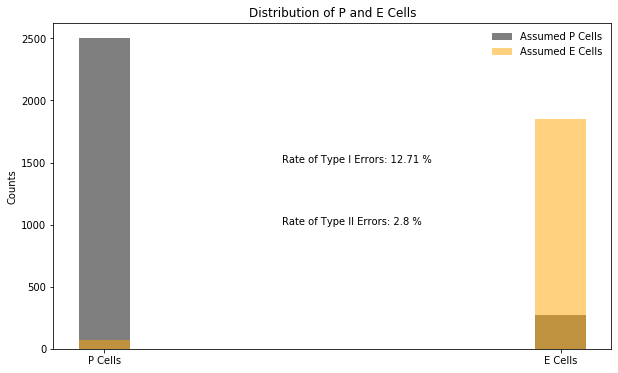

In [303]:
fig=plt.figure(figsize=(10,6))
plt.hist(data_Cells[0][guess_p],color='black',label='Assumed P Cells',bins=10,alpha=0.5)
plt.hist(data_Cells[0][guess_e],color='orange',label='Assumed E Cells',bins=10,alpha=0.5)
plt.text(x=0.4,y=1500,s=f'Rate of Type I Errors: {np.round(alpha*100,2)} %')
plt.text(x=0.4,y=1000,s=f'Rate of Type II Errors: {np.round(beta*100,2)} %')
plt.legend(frameon=False)
t1 = [0.05,0.95]
t2 = ['P Cells','E Cells']
plt.xticks(t1, t2)
plt.ylabel('Counts')
plt.title('Distribution of P and E Cells')
fig.savefig('{0}/{1}.pdf'.format(figpath,'opg_4_1_A'), bbox_inches="tight")

#### B) Which of the two variables $l$ and $T$ is best at distinguishing between P and E cells?

In [304]:
def roc_curve(signal, background, Nbins, bmin, bmax):

    # bmin/bmax = range for binning
    # signal,background = arrays
    # Nbins = number of bins (int)
    
    count_s, bin_edges_s = np.histogram(signal,bins=Nbins,range=(bmin,bmax))
    count_b, bin_edges_b = np.histogram(background,bins=Nbins,range=(bmin,bmax))
    bin_centers = (bin_edges_s[1:] + bin_edges_s[:-1])/2
            
    sum_s = np.sum(count_s)
    sum_b = np.sum(count_b)
    
    tpr = np.zeros_like(count_s,dtype=float) 
    fpr = np.zeros_like(count_s,dtype=float) 
        
    for i, b in enumerate(bin_centers): 
            
        under = np.argwhere(bin_centers < b)
        over  = np.argwhere(bin_centers >= b)
            
        tp = np.sum(count_s[over])/sum_s    
        fn = np.sum(count_s[under])/sum_s     
        tpr[i] = tp/(tp+fn)                    
            
        tn = np.sum(count_b[under])/sum_b      
        fp = np.sum(count_b[over])/sum_b     
        fpr[i] = fp/(fp+tn)                                
            
    return tpr,fpr

#### C) Separate P and E cells using $l$ and/or $T$, and draw a ROC curve of your result.

In [305]:
from numpy.linalg import inv

def fisher_lda(A,B):
    
    mu_A = np.array([np.mean(A[:, 0]),np.mean(A[:, 1])]) 
    mu_B = np.array([np.mean(B[:, 0]),np.mean(B[:, 1])]) 
    
    cov_A = np.cov(A,rowvar=False)
    cov_B = np.cov(B,rowvar=False)
    
    cov_sum = cov_A + cov_B
    
    cov_sum_inv = inv(cov_sum)
    
    wf = cov_sum_inv.dot((mu_A-mu_B)) 

    fisher_data_A = wf.dot(np.transpose(A))
    fisher_data_B = wf.dot(np.transpose(B))
    
    return fisher_data_A,fisher_data_B

def calc_separation(x, y):
    
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    
    std_x = np.std(x, ddof=1)
    std_y = np.std(y, ddof=1)
    d = np.abs((mean_x - mean_y)) / np.sqrt(std_x**2 + std_y**2)
        
    return d

In [306]:
pcells = np.array([[length[p_cells][i,0],transparency[p_cells][i,0]] for i in range(len(p_cells))])
ecells = np.array([[length[e_cells][i,0],transparency[e_cells][i,0]] for i in range(len(e_cells))])

In [307]:
fisher_e,fisher_p = fisher_lda(ecells,pcells)
fish = np.concatenate((fisher_e,fisher_p),axis=0)

In [308]:
tpr_f,fpr_f = roc_curve(fisher_e, fisher_p, 100, fish.min(),fish.max())
tpr_l,fpr_l = roc_curve(length[e_cells], length[p_cells], 100, length.min(), length.max())
tpr_t,fpr_t = roc_curve(transparency[e_cells],transparency[p_cells], 100, transparency.min(), transparency.max())

In [309]:
df=calc_separation(fisher_e,fisher_p)
dl=calc_separation(length[e_cells],length[p_cells])
dt=calc_separation(transparency[e_cells],transparency[p_cells])

print('Fisher:      ',df)
print('Length:      ',dl)
print('Transparency:',dt)

Fisher:       2.6142481445118295
Length:       1.494402012208019
Transparency: 2.2204223921591577


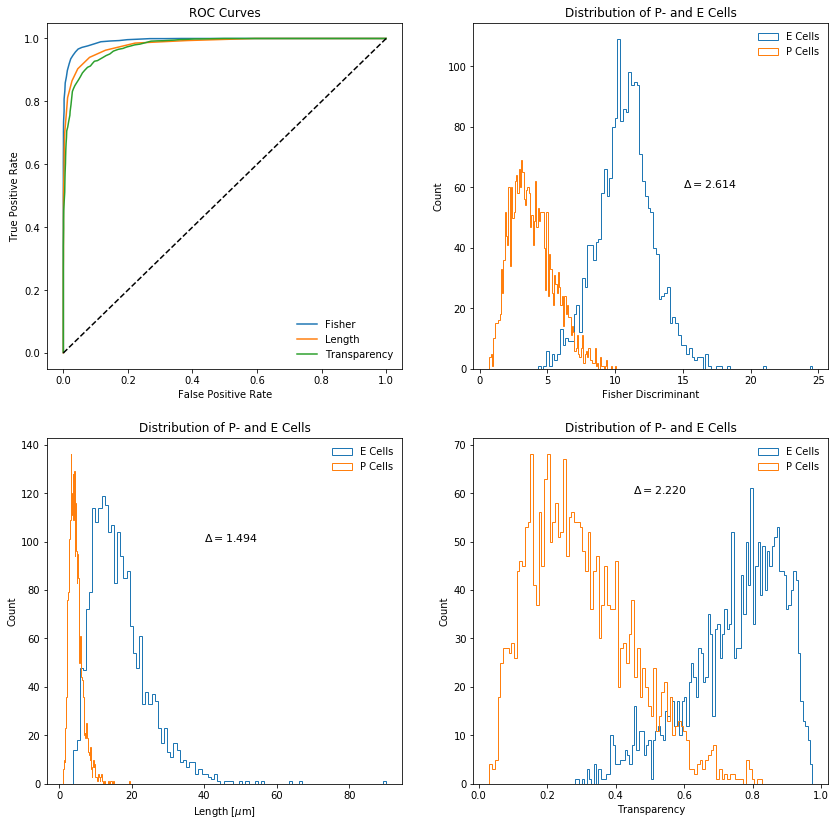

In [310]:
fig,axes=plt.subplots(figsize=(14,14),nrows=2,ncols=2)
ax1 = axes[0,0]
ax2 = axes[0,1]
ax3 = axes[1,0]
ax4 = axes[1,1]

ax1.plot(fpr_f,tpr_f,label='Fisher',color='C0')
ax1.plot(fpr_l,tpr_l,label='Length',color='C1')
ax1.plot(fpr_t,tpr_t,label='Transparency',color='C2')
ax1.plot(np.linspace(0,1,10),np.linspace(0,1,10),linestyle='--',color='k')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves')
ax1.legend(frameon=False)

ax2.hist(fisher_e,100,histtype='step',label='E Cells');
ax2.hist(fisher_p,100,histtype='step',label='P Cells');
ax2.set_xlabel('Fisher Discriminant')
ax2.set_ylabel('Count')
ax2.set_title('Distribution of P- and E Cells')
ax2.text(15, 60, fr'$\Delta = {df:.3f}$', fontsize=11,color='k')
ax2.legend(frameon=False)

ax3.hist(length[e_cells],100,histtype='step',label='E Cells');
ax3.hist(length[p_cells],100,histtype='step',label='P Cells');
ax3.set_xlabel(r'Length [$\mu$m]')
ax3.set_ylabel('Count')
ax3.set_title('Distribution of P- and E Cells')
ax3.text(40, 100, fr'$\Delta = {dl:.3f}$', fontsize=11,color='k')
ax3.legend(frameon=False)

ax4.hist(transparency[e_cells],100,histtype='step',label='E Cells');
ax4.hist(transparency[p_cells],100,histtype='step',label='P Cells');
ax4.set_xlabel(r'Transparency')
ax4.set_ylabel('Count')
ax4.set_title('Distribution of P- and E Cells')
ax4.text(0.45, 60, fr'$\Delta = {dt:.3f}$', fontsize=11,color='k')
ax4.legend(frameon=False)

fig.savefig('{0}/{1}.pdf'.format(figpath,'opg_4_1_c'), bbox_inches="tight")

In [311]:
s_f = np.array(tpr_f)[fpr_f!=0]
b_f = 1-np.array(fpr_f)[fpr_f!=0]
bs_f = np.sqrt(np.array(fpr_f))[fpr_f!=0]
o_f = s_f/bs_f

s_l = np.array(tpr_l)[fpr_l!=0]
b_l = 1-np.array(fpr_l)[fpr_l!=0]
bs_l = np.sqrt(np.array(fpr_l))[fpr_l!=0]
o_l = s_l/bs_l

s_t = np.array(tpr_t)[fpr_t!=0]
b_t = 1-np.array(fpr_t)[fpr_t!=0]
bs_t = np.sqrt(np.array(fpr_t))[fpr_t!=0]
o_t = s_t/bs_t

(0.0, 1.0, 0.0, 1.0)

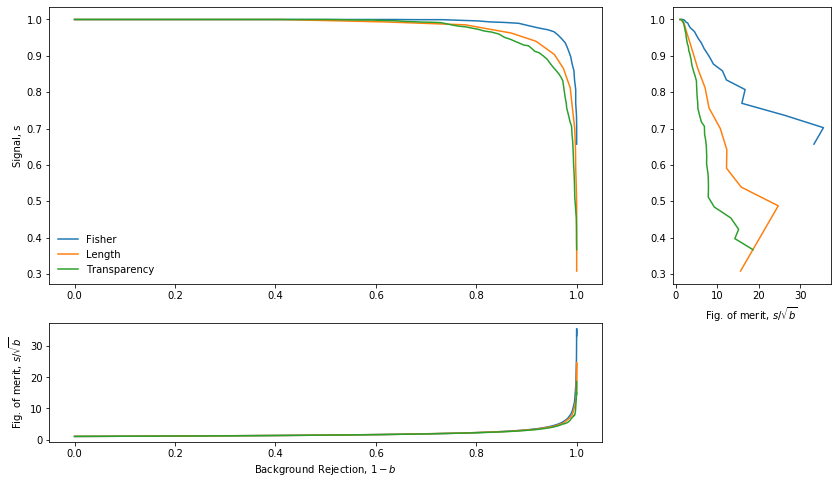

In [312]:
fig,axes=plt.subplots(figsize=(14,8),nrows=2,ncols=2,gridspec_kw={'height_ratios':[7,3],'width_ratios':[7,2]})
ax1 = axes[0,0]
ax2 = axes[1,0]
ax3 = axes[0,1]
ax4 = axes[1,1]

ax1.plot(b_f,s_f,label='Fisher',color='C0')
ax1.plot(b_l,s_l,label='Length',color='C1')
ax1.plot(b_t,s_t,label='Transparency',color='C2')
ax1.set_ylabel(r'Signal, s')
ax1.legend(frameon=False)

ax2.plot(b_f,o_f,label='Fisher',color='C0')
ax2.plot(b_l,o_l,label='Length',color='C1')
ax2.plot(b_t,o_t,label='Transparency',color='C2')
ax2.set_xlabel(r'Background Rejection, $1-b$')
ax2.set_ylabel(r'Fig. of merit, $s/\sqrt{b}$')

ax3.plot(o_f,s_f,label='Fisher',color='C0')
ax3.plot(o_l,s_l,label='Length',color='C1')
ax3.plot(o_t,s_t,label='Transparency',color='C2')
ax3.set_xlabel(r'Fig. of merit, $s/\sqrt{b}$')

ax4.axis('off')

In [317]:
def tpr_fpr(x,param):
            
    guess_p = np.argwhere(param<x)
    guess_e = np.argwhere(param>=x)
    
    tp = 0
    fn = 0
    fp = 0
    tn = 0

    for i in range(len(data_Cells[0][guess_p])):
        if data_Cells[0][guess_p][i]==0:
            tp += 1
        if data_Cells[0][guess_p][i]==1:
            fp += 1

    for i in range(len(data_Cells[0][guess_e])):
        if data_Cells[0][guess_e][i]==1:
            tn += 1
        if data_Cells[0][guess_e][i]==0:
            fn += 1

    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    
    return tpr,fpr

In [318]:
count_l,bin_edges_l = np.histogram(length,100,range=(length.min(), length.max()))
length_choice = ((bin_edges_l[1:]+bin_edges_l[:-1])/2)

sums=[]
alpha,beta=[],[]

for i in range(len(length)):

    tpr,fpr = tpr_fpr(length[i],length)
    a = fpr*100
    b = (1-tpr)*100
    sums.append(a+b)
    alpha.append(a)
    beta.append(b)

In [319]:
opt_l = np.argmin(sums)
print('Length:',length[opt_l])
print('Type I:',alpha[opt_l])
print('Type II:',beta[opt_l])

Length: 7.9692
Type I: 8.128544423440454
Type II: 5.24475524475524


In [320]:
sums=[]
alpha,beta=[],[]

for i in range(len(transparency)):

    tpr,fpr = tpr_fpr(transparency[i],transparency)
    a = fpr*100
    b = (1-tpr)*100
    sums.append(a+b)
    alpha.append(a)
    beta.append(b)

In [321]:
opt_t = np.argmin(sums)
print('Transparency:',transparency[opt_t])
print('Type I:',alpha[opt_t])
print('Type II:',beta[opt_t])

Transparency: 0.5451
Type I: 9.546313799621927
Type II: 6.99300699300699


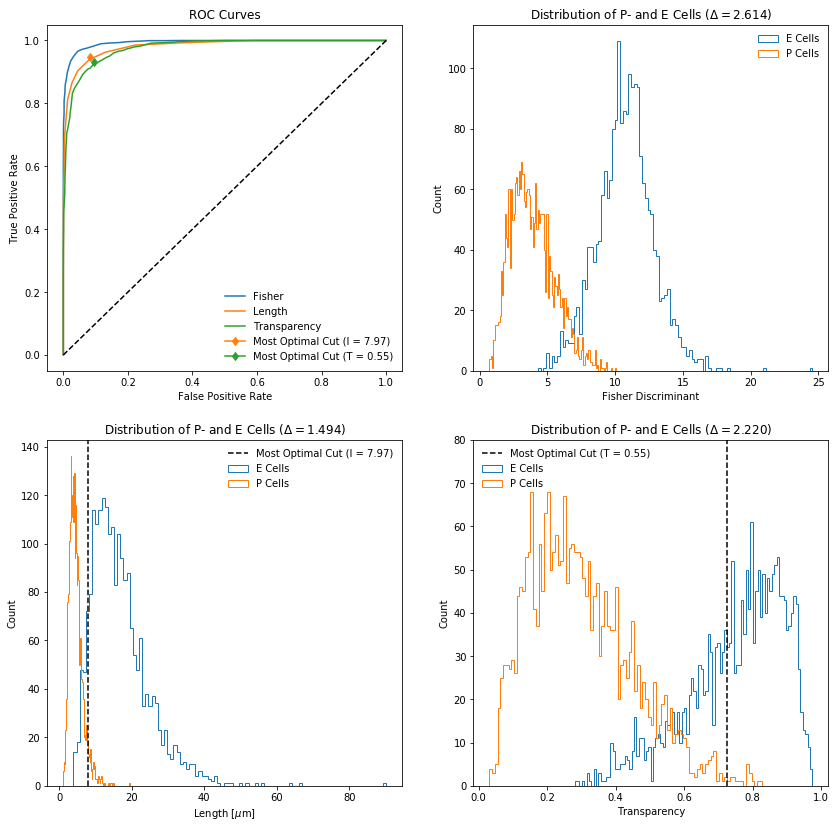

In [323]:
fig,axes=plt.subplots(figsize=(14,14),nrows=2,ncols=2)
ax1 = axes[0,0]
ax2 = axes[0,1]
ax3 = axes[1,0]
ax4 = axes[1,1]

ax1.plot(fpr_f,tpr_f,label='Fisher',color='C0')
ax1.plot(fpr_l,tpr_l,label='Length',color='C1')
ax1.plot(fpr_t,tpr_t,label='Transparency',color='C2')

tpr,fpr = tpr_fpr(length[opt_l],length)
ax1.plot(fpr,tpr,label=f'Most Optimal Cut (l = {np.round(length[opt_l],2)})',color='C1',marker='d')

tpr,fpr = tpr_fpr(transparency[opt_t],transparency)
ax1.plot(fpr,tpr,label=f'Most Optimal Cut (T = {np.round(transparency[opt_t],2)})',color='C2',marker='d')

ax1.plot(np.linspace(0,1,10),np.linspace(0,1,10),linestyle='--',color='k')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves')
ax1.legend(frameon=False)

ax2.hist(fisher_e,100,histtype='step',label='E Cells');
ax2.hist(fisher_p,100,histtype='step',label='P Cells');
ax2.set_xlabel('Fisher Discriminant')
ax2.set_ylabel('Count')
ax2.set_title(fr'Distribution of P- and E Cells ($\Delta = {df:.3f}$)')
ax2.legend(frameon=False)

ax3.hist(length[e_cells],100,histtype='step',label='E Cells');
ax3.hist(length[p_cells],100,histtype='step',label='P Cells');
ax3.axvline(length[opt],linestyle='--',color='k',label=f'Most Optimal Cut (l = {np.round(length[opt_l],2)})')
ax3.set_xlabel(r'Length [$\mu$m]')
ax3.set_ylabel('Count')
ax3.set_title(fr'Distribution of P- and E Cells ($\Delta = {dl:.3f}$)')
ax3.legend(frameon=False)

ax4.hist(transparency[e_cells],100,histtype='step',label='E Cells');
ax4.hist(transparency[p_cells],100,histtype='step',label='P Cells');
ax4.axvline(transparency[opt],linestyle='--',color='k',label=f'Most Optimal Cut (T = {np.round(transparency[opt_t],2)})')
ax4.set_xlabel(r'Transparency')
ax4.set_ylabel('Count')
ax4.set_title(fr'Distribution of P- and E Cells ($\Delta = {dt:.3f}$)')
ax4.legend(frameon=False)
ax4.set_ylim(0,80)

fig.savefig('{0}/{1}.pdf'.format(figpath,'opg_4_1_C'), bbox_inches="tight")

## V) Fitting data

### 5.1) (15 points) Kepler’s third law states that “the square of the orbital period ($T$) of a planet is directly proportional to the cube of the semi-major axis ($a$) of its orbit”. The table lists values for $T$ in days (known very precisely) and $a$ in AU ($= 149597870700$ m) at the time of the first measurement (in 1778) of the gravitational constant $G_{1778} = (7.5 \pm 1.0) \times 10^{−11}$m$^3$kg$^{−1}$s$^{−2}$.

<img src="table.png" alt="Drawing" style="width: 400px;"/>

#### A) Plot the five non-Earth values and fit these to Kepler’s third Law: $a = C \times T^{2/3}$.

In [153]:
T       = np.array([87.77,224.70,686.95,4332.62,10759.2])
a_val   = np.array([0.389,0.724,1.524,5.20,9.51])
a_err   = np.array([0.011,0.020,0.037,0.13,0.34])
planets = ['Mercury','Venus','Mars','Jupiter','Saturn']

In [154]:
def kepler(T,C):
    return C*T**(2/3)

chi2_object = Chi2Regression(kepler, T, a_val, a_err)
minuit = Minuit(chi2_object, print_level=0, pedantic=False, C=0.02)
minuit.migrad(); # fit

In [155]:
if (not minuit.fmin.is_valid) :
    print("  WARNING: The ChiSquare fit DID NOT converge!!! ")

In [156]:
C = minuit.args
C0 = minuit.args

print("Kepler fit")
for name in minuit.parameters:
    print("Fit value: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit.values[name], minuit.errors[name]))

Kepler fit
Fit value: C = 0.01959 +/- 0.00024


In [157]:
xrange = np.arange(T.min(),T.max())
xrange0 = np.arange(T.min(),T.max())

In [158]:
chi2_val_fit = minuit.fval
print('Chi2 value of fit:',chi2_val_fit)
Ndata = len(T)
N_DOF = Ndata - len(minuit.args)
print('Degrees of freedom: ',N_DOF)
chi2_prob =  stats.chi2.sf(chi2_val_fit, N_DOF)
print('Chi2 probability',chi2_prob)

d0 = {'Entries':  Ndata,
     'Chi2':     chi2_val_fit,
     'ndf':      N_DOF,
     'Prob':     chi2_prob,
    }

for name in minuit.parameters:
    d0[name] = [minuit.values[name], minuit.errors[name]]

Chi2 value of fit: 0.0519839807771334
Degrees of freedom:  4
Chi2 probability 0.9996680048133179


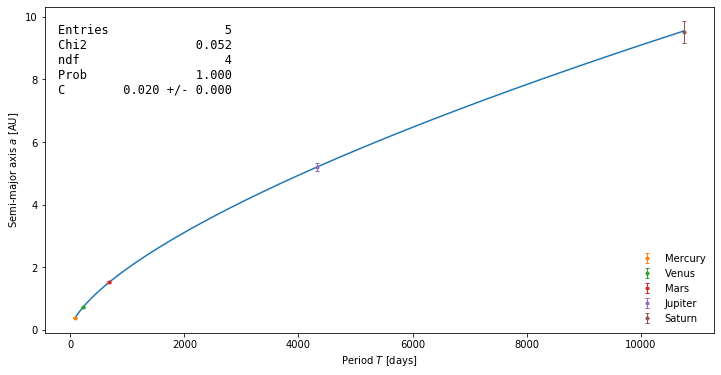

In [159]:
fig, ax2 = plt.subplots(figsize=(12, 6))
plt.plot(xrange,kepler(xrange,C),marker=None,linestyle='-')
for i in range(len(T)):
    plt.errorbar(T[i], a_val[i], yerr=a_err[i], xerr=None, elinewidth=1, capsize=2,linestyle='None',marker='.',label=planets[i]);
plt.legend(frameon=False,loc='lower right')
plt.xlabel(r'Period $T$ [days]');
plt.ylabel(r'Semi-major axis $a$ [AU]');
text = nice_string_output(d0, extra_spacing=2, decimals=3);
add_text_to_ax(0.02, 0.95, text, ax2, fontsize=12);

#### B) In this fit, which planet seems to follow this relation least well? Is it critical?


In [160]:
residuals = a_val-kepler(T,C)
res_std = residuals.std(ddof=1)

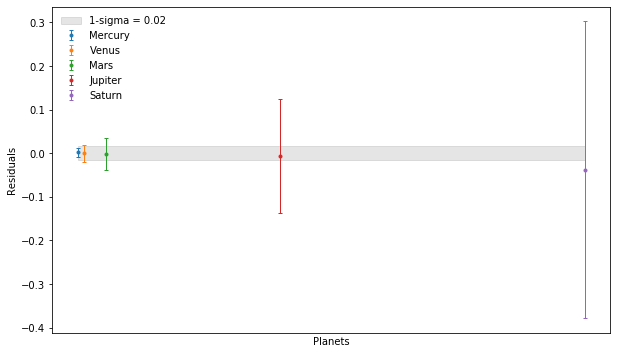

In [161]:
fig=plt.figure(figsize=(10,6))
plt.fill_between(T,-res_std,res_std,alpha=0.1,color='black',label=f'1-sigma = {np.round(res_std,2)}')
for i in range(len(T)):
    plt.errorbar(T[i], residuals[i], yerr=a_err[i], xerr=None, elinewidth=1, capsize=2,linestyle='None',marker='.',label=planets[i]);
plt.xlabel('Planets')
plt.xticks([])
plt.ylabel('Residuals')
plt.legend(frameon=False)
fig.savefig('{0}/{1}.pdf'.format(figpath,'opg_5_1_B'), bbox_inches="tight")

In [162]:
np.abs(residuals[-1])/res_std

2.2817680999472696

Saturn follows least well with residual $2.28\sigma$ away from 0, and I would not call it critical as it is still within $3\sigma$.

#### C) From the value you obtain for $C$ and $G_{1778}$ estimate the solar mass $M = 4\pi^2C^3/G$ in kg.

In [163]:
C0,errC0 = minuit.values['C'],minuit.errors['C']

from astropy import units as U
from astropy import constants as C

In [164]:
AU = 149597870700
day = 60*60*24
G = 7.5*10**(-11)
errG = 10**(-11)

C = C0*AU/(day**(2/3))
errC = errC0*AU/(day**(2/3))

dmdc = 12*np.pi**2*C**2/G
dmdg = 4*np.pi**2*C**3/(G**2)

M = 4*np.pi**2*C**3/G
dM = np.sqrt((dmdc*errC)**2+(dmdg*errG)**2)
print(f"{M:.2} +- {dM:.1}")

1.8e+30 +- 2e+29


#### D) Expand the fit to Kepler’s third law by further adding two parameters: $a = C \times (T^{c_1} + c_2)$. Does this formula match the data well? Are the two additional parameters necessary?!

In [165]:
def kepler_advanced(T,C,c1,c2):
    return C*(T**c1+c2)

chi2_object = Chi2Regression(kepler_advanced, T, a_val, a_err)
minuit = Minuit(chi2_object, print_level=0, pedantic=False, C=0.02, c1=2/3, c2=0)
minuit.migrad(); # fit

In [166]:
if (not minuit.fmin.is_valid) :
    print("  WARNING: The ChiSquare fit DID NOT converge!!! ")

In [167]:
C,c1,c2 = minuit.args
print("Kepler fit")
for name in minuit.parameters:
    print("Fit value: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit.values[name], minuit.errors[name]))

Kepler fit
Fit value: C = 0.01950 +/- 0.00299
Fit value: c1 = 0.66685 +/- 0.01815
Fit value: c2 = 0.16889 +/- 1.75461


In [168]:
chi2_val_fit = minuit.fval
print('Chi2 value of fit:',chi2_val_fit)
Ndata = len(T)
N_DOF = Ndata - len(minuit.args)
print('Degrees of freedom: ',N_DOF)
chi2_prob =  stats.chi2.sf(chi2_val_fit, N_DOF)
print('Chi2 probability',chi2_prob)

d = {'Entries':  Ndata,
     'Chi2':     chi2_val_fit,
     'ndf':      N_DOF,
     'Prob':     chi2_prob,
    }

for name in minuit.parameters:
    d[name] = [minuit.values[name], minuit.errors[name]]

Chi2 value of fit: 0.0059381473139365135
Degrees of freedom:  2
Chi2 probability 0.9970353296831969


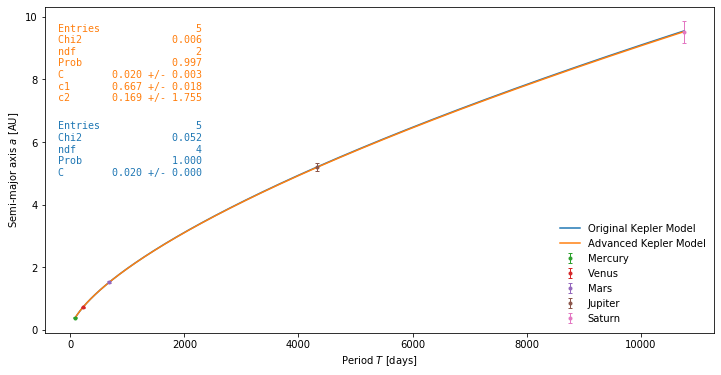

In [169]:
fig, ax2 = plt.subplots(figsize=(12, 6))
plt.plot(xrange,kepler(xrange0,C0),marker=None,linestyle='-',label='Original Kepler Model')
plt.plot(xrange,kepler_advanced(xrange,C,c1,c2),marker=None,linestyle='-',label='Advanced Kepler Model')
for i in range(len(T)):
    plt.errorbar(T[i], a_val[i], yerr=a_err[i], xerr=None, elinewidth=1, capsize=2,linestyle='None',marker='.',label=planets[i]);
plt.legend(frameon=False, loc='lower right')
plt.xlabel(r'Period $T$ [days]');
plt.ylabel(r'Semi-major axis $a$ [AU]');
text = nice_string_output(d0, extra_spacing=2, decimals=3);
add_text_to_ax(0.02, 0.65, text, ax2, fontsize=10,color='C0');
text = nice_string_output(d, extra_spacing=2, decimals=3);
add_text_to_ax(0.02, 0.95, text, ax2, fontsize=10,color='C1');
fig.savefig('{0}/{1}.pdf'.format(figpath,'opg_5_1_D'), bbox_inches="tight")

It still fits the data well, but the original law was better. Thus, the two extra parameters, $c_1$ and $c_2$, are not needed. It should be noted however, for both fits, they are "too good" as the errors on Jupiter and Saturn are too high. If the errors on the semi-major axis for these planets were known to a better degree, the resulting fit would be more trustworthy.

### 5.2) (15 points) Searching for slow moving (compared to speed of light) particles at CERN’s LHC accelerator, you are calibrating the speed measurement $\beta = v/c$ of the candidate particles, using a control sample of particles known to (effectively) travel at the speed of light, i.e. $\beta = 1$. The file www.nbi.dk/∼petersen/data_BetaCalibration.txt contains 4000 control sample measurements of initial speed estimate ($\beta_{init}$), energy ($E$) in GeV, angle with respect to the beam axis ($\theta$) in radians, and time since start of experiment ($T$) in seconds, respectively.
#### A) What is the resolution of $\beta_{\rm init}$? And is it consistent with a Gaussian distribution?

In [228]:
data_BetaCalibration = np.genfromtxt("data_BetaCalibration.txt", unpack=True)

In [229]:
beta_init = data_BetaCalibration[0]
theta = data_BetaCalibration[1]
energy = data_BetaCalibration[2]
time = data_BetaCalibration[3]

In [230]:
beta_init.std(ddof=1)

0.09115189135625194

In [231]:
normal = np.random.normal(loc=beta_init.mean(),scale=beta_init.std(ddof=1),size=len(beta_init))

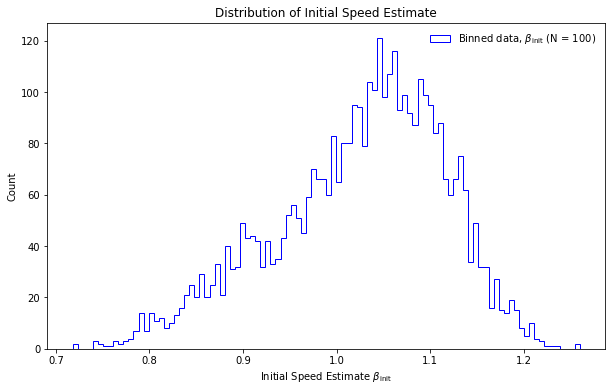

In [232]:
fig=plt.figure(figsize=(10,6))
plt.hist(beta_init,color='blue',label=r'Binned data, $\beta_{\rm init}$ (N = 100)',histtype='step',bins=100)
#plt.hist(normal,color='red',label=r'Normal distribution',histtype='step',bins=100)
plt.legend(frameon=False)
plt.title('Distribution of Initial Speed Estimate')
plt.ylabel('Count')
plt.xlabel(r'Initial Speed Estimate $\beta_{\rm init}$')
fig.savefig('{0}/{1}.pdf'.format(figpath,'opg_5_2_A'), bbox_inches="tight")

In [233]:
par      = beta_init
kurtosis = stats.kurtosis(par, bias=False)
skew     = stats.skew(par, bias=False)
print('Beta')
print('Kurtosis:',kurtosis)
print('Skew:    ',skew)
print('')
par      = normal
kurtosis = stats.kurtosis(par, bias=False)
skew     = stats.skew(par, bias=False)
print('Normal')
print('Kurtosis:',kurtosis)
print('Skew:    ',skew)

Beta
Kurtosis: -0.18108143184618442
Skew:     -0.5169773466947889

Normal
Kurtosis: 0.10176990996858404
Skew:     -0.008189275916640355


#### B) Is the distribution in $\theta$ consistent with being symmetric around $\pi/2$?

Text(0.5, 0, 'Angle wrt. Beam Axis $\\theta$')

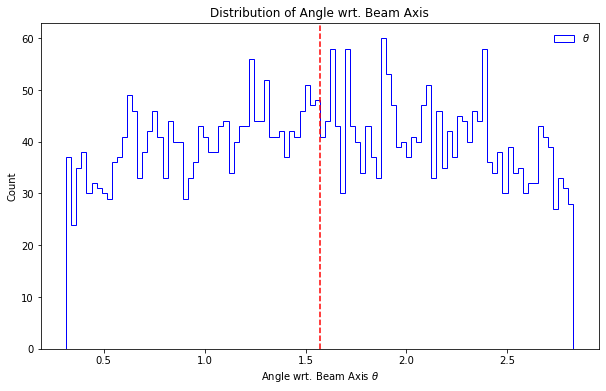

In [234]:
fig=plt.figure(figsize=(10,6))
plt.hist(theta,color='blue',label=r'$\theta$',histtype='step',bins=100)
plt.legend(frameon=False)
plt.title('Distribution of Angle wrt. Beam Axis')
plt.axvline(x=np.pi/2,linestyle='--',color='red',label=r'$\pi/2$')
plt.ylabel('Count')
plt.xlabel(r'Angle wrt. Beam Axis $\theta$')

In [235]:
print(len(theta[theta<=np.pi/2]))
print(len(theta[theta>np.pi/2]))

1989
2011


In [236]:
print('Mean:  ',np.mean(theta))
print('Median:',np.median(theta))
print('pi/2:  ',np.pi/2)
print('Difference (mean and median):',np.abs(np.mean(theta)-np.median(theta)))
print('Difference (mean and pi/2):  ',np.abs(np.mean(theta)-np.pi/2))
print('Difference (median and pi/2):',np.abs(np.pi/2-np.median(theta)))
print('')
par      = theta
kurtosis = stats.kurtosis(par, bias=False)
skew     = stats.skew(par, bias=False)
print('Kurtosis:',kurtosis)
print('Skew:    ',skew)

Mean:   1.5755733749999998
Median: 1.5773000000000001
pi/2:   1.5707963267948966
Difference (mean and median): 0.0017266250000003147
Difference (mean and pi/2):   0.004777048205103274
Difference (median and pi/2): 0.006503673205103588

Kurtosis: -1.115075398791169
Skew:     -0.01627399548030026


In [237]:
np.where(theta==float(stats.mode(theta)[0]))

(array([1008, 1715, 2035]),)

#### C) Test if the mean of $\beta_{init}$ is constant as a function of energy.

In [238]:
def binning(x,y,n):
    xmin = x.min()
    xmax = x.max()
    size = (xmax-xmin)/n
    curr_x = 0
    saves = []
    xes = []
    std = []
    while curr_x<xmax:
        interest = np.where((x>=curr_x)&(x<curr_x+size))[0]
        if len(interest)>5:
            saves.append(y[interest].mean())
            xes.append(curr_x+size/2)
            std.append(y[interest].std(ddof=1))
        curr_x+=size
    return saves,xes,std

In [239]:
def linear(x,a,b):
    return a*x+b

In [240]:
beta_plot,energy_plot,std = binning(energy,beta_init,100)

In [241]:
slope,intercept,rval,pval,stderr = linregress(energy_plot,beta_plot)

chi2_object = Chi2Regression(linear, energy,beta_init)
minuit = Minuit(chi2_object, print_level=0, pedantic=False, a=slope,b=intercept)
minuit.migrad(); 

if (not minuit.fmin.is_valid) :
    print("  WARNING: The ChiSquare fit DID NOT converge!!! ")
    
for name in minuit.parameters:
    print("Fit value: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit.values[name], minuit.errors[name]))
    
chi2_val_fit = minuit.fval
print('Chi2 value of fit:',chi2_val_fit)
Ndata = len(energy_plot)
N_DOF = Ndata - len(minuit.args)
print('Degrees of freedom: ',N_DOF)
chi2_prob =  stats.chi2.sf(chi2_val_fit, N_DOF)
print('Chi2 probability',chi2_prob)

d = {'Entries':  Ndata,
     'Chi2':     chi2_val_fit,
     'ndf':      N_DOF,
     'Prob':     chi2_prob,
    }

for name in minuit.parameters:
    d[name] = [minuit.values[name], minuit.errors[name]]

Fit value: a = -0.00175 +/- 0.00101
Fit value: b = 1.04924 +/- 0.02148
Chi2 value of fit: 30.191961988588908
Degrees of freedom:  33
Chi2 probability 0.6076487317075447


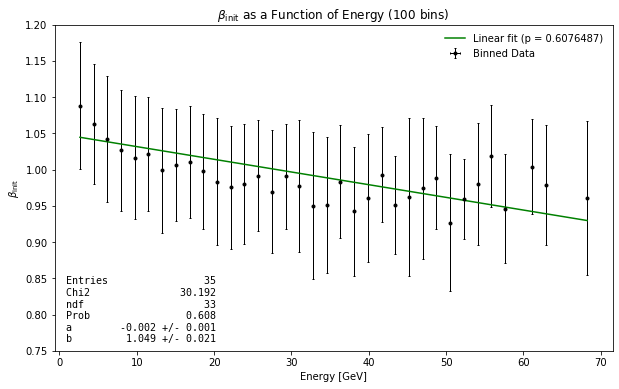

In [242]:
fig,axes=plt.subplots(nrows=1,ncols=1,figsize=(10,6))
axes.errorbar(energy_plot,beta_plot,xerr=0,yerr=std,fmt='.k',elinewidth=1,capthick=1,capsize=1,label='Binned Data')
axes.plot(energy_plot,linear(np.array(energy_plot),*minuit.args),linestyle='-',color='green',label=f'Linear fit (p = {np.round(chi2_prob,7)})')
plt.title(r'$\beta_{\rm init}$ as a Function of Energy (100 bins)')
axes.set_xlabel('Energy [GeV]')
axes.set_ylabel(r'$\beta_{\rm init}$')
axes.legend(frameon=False)
axes.set_ylim(0.75,1.2)
text = nice_string_output(d, extra_spacing=2, decimals=3);
add_text_to_ax(0.02, 0.23, text, axes, fontsize=10);
fig.savefig('{0}/{1}.pdf'.format(figpath,'opg_5_2_C'), bbox_inches="tight")

#### D) Due to shifts in timing, the central value of $\beta_{init}$ shifted with time $T$, smearing the resolution. Calibrate $\beta_{init}$ with respect to $T$ and determine the obtained resolution on $\beta_{T-calib}$.

In [243]:
beta_plot,time_plot,std = binning(time,beta_init,200)

<ErrorbarContainer object of 3 artists>

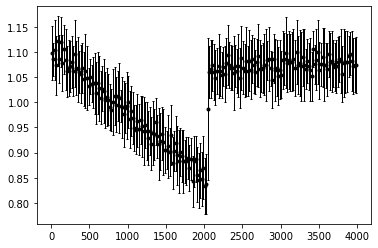

In [244]:
plt.errorbar(time_plot,beta_plot,xerr=0,yerr=std,fmt='.k',elinewidth=1,capthick=1,capsize=1,label='Binned Data')

In [245]:
find_jump = []

for i in range(len(beta_plot)-1):
    find_jump.append(beta_plot[i+1]-beta_plot[i])
    
jump = np.where(find_jump == np.max(find_jump))[0]
jump_time = np.array(time_plot)[jump]

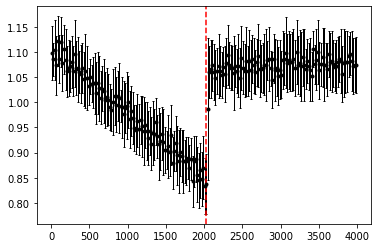

In [246]:
plt.errorbar(time_plot,beta_plot,xerr=0,yerr=std,fmt='.k',elinewidth=1,capthick=1,capsize=1,label='Binned Data')
plt.axvline(jump_time,linestyle='--',color='red')

In [247]:
left_beta  = np.array(beta_plot)[time_plot<=jump_time]
right_beta = np.array(beta_plot)[time_plot>jump_time]
left_time  = np.array(time_plot)[time_plot<=jump_time]
right_time = np.array(time_plot)[time_plot>jump_time]
left_std   = np.array(std)[time_plot<=jump_time]
right_std  = np.array(std)[time_plot>jump_time]

<ErrorbarContainer object of 3 artists>

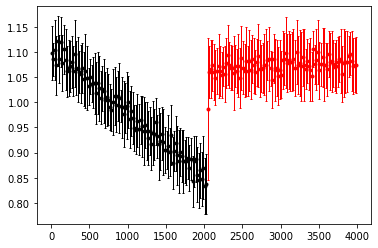

In [248]:
plt.errorbar(right_time,right_beta,xerr=0,yerr=np.array(std)[time_plot>jump_time],fmt='.r',elinewidth=1,capthick=1,capsize=1,label='Binned Data')
plt.errorbar(left_time,left_beta,xerr=0,yerr=np.array(std)[time_plot<=jump_time],fmt='.k',elinewidth=1,capthick=1,capsize=1,label='Binned Data')

In [249]:
slope,intercept,rval,pval,stderr = linregress(left_time,left_beta)

chi2_object = Chi2Regression(linear, left_time,left_beta,left_std)
minuit = Minuit(chi2_object, print_level=0, pedantic=False, a=slope,b=intercept)
minuit.migrad(); 

if (not minuit.fmin.is_valid) :
    print("  WARNING: The ChiSquare fit DID NOT converge!!! ")
    
for name in minuit.parameters:
    print("Fit value: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit.values[name], minuit.errors[name]))
    
chi2_val_fit = minuit.fval
print('Chi2 value of fit:',chi2_val_fit)
Ndata = len(left_time)
N_DOF = Ndata - len(minuit.args)
print('Degrees of freedom: ',N_DOF)
chi2_prob =  stats.chi2.sf(chi2_val_fit, N_DOF)
print('Chi2 probability',chi2_prob)

d = {'Entries':  Ndata,
     'Chi2':     chi2_val_fit,
     'ndf':      N_DOF,
     'Prob':     chi2_prob,
    }

for name in minuit.parameters:
    d[name] = [minuit.values[name], minuit.errors[name]]
    
d_l = d
chi2_prob_l = chi2_prob
chi2_val_l = chi2_val_fit
args_l = minuit.args

Fit value: a = -0.00013 +/- 0.00001
Fit value: b = 1.10555 +/- 0.00998
Chi2 value of fit: 6.442777960727645
Degrees of freedom:  100
Chi2 probability 1.0


In [250]:
slope,intercept,rval,pval,stderr = linregress(right_time,right_beta)

chi2_object = Chi2Regression(linear, right_time,right_beta,right_std)
minuit = Minuit(chi2_object, print_level=0, pedantic=False, a=slope,b=intercept)
minuit.migrad(); 

if (not minuit.fmin.is_valid) :
    print("  WARNING: The ChiSquare fit DID NOT converge!!! ")
    
for name in minuit.parameters:
    print("Fit value: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit.values[name], minuit.errors[name]))
    
chi2_val_fit = minuit.fval
print('Chi2 value of fit:',chi2_val_fit)
Ndata = len(right_time)
N_DOF = Ndata - len(minuit.args)
print('Degrees of freedom: ',N_DOF)
chi2_prob =  stats.chi2.sf(chi2_val_fit, N_DOF)
print('Chi2 probability',chi2_prob)

d = {'Entries':  Ndata,
     'Chi2':     chi2_val_fit,
     'ndf':      N_DOF,
     'Prob':     chi2_prob,
    }

for name in minuit.parameters:
    d[name] = [minuit.values[name], minuit.errors[name]]
    
d_r = d
chi2_prob_r = chi2_prob
chi2_val_r = chi2_val_fit
args_r = minuit.args

Fit value: a = 0.00001 +/- 0.00001
Fit value: b = 1.04552 +/- 0.02866
Chi2 value of fit: 4.970955097048949
Degrees of freedom:  96
Chi2 probability 1.0


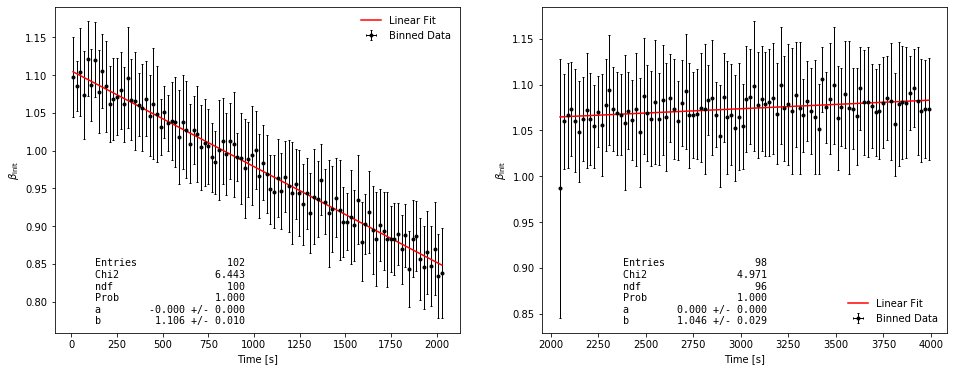

In [251]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(16,6))

ax1 = axes[1]
ax2 = axes[0]

ax1.errorbar(right_time,right_beta,xerr=0,yerr=np.array(std)[time_plot>jump_time],fmt='.k',elinewidth=1,capthick=1,capsize=1,label='Binned Data')
ax1.plot(right_time,linear(right_time,*args_r),linestyle='-',color='red',label='Linear Fit')
text = nice_string_output(d_r, extra_spacing=2, decimals=3);
add_text_to_ax(0.2, 0.23, text, ax1, fontsize=10);
ax1.set_xlabel('Time [s]')
ax1.set_ylabel(r'$\beta_{\rm init}$')
ax1.legend(frameon=False,loc='lower right')

ax2.errorbar(left_time,left_beta,xerr=0,yerr=np.array(std)[time_plot<=jump_time],fmt='.k',elinewidth=1,capthick=1,capsize=1,label='Binned Data')
ax2.plot(left_time,linear(left_time,*args_l),linestyle='-',color='red',label='Linear Fit')
text = nice_string_output(d_l, extra_spacing=2, decimals=3);
add_text_to_ax(0.1, 0.23, text, ax2, fontsize=10);
ax2.set_xlabel('Time [s]')
ax2.set_ylabel(r'$\beta_{\rm init}$')
ax2.legend(frameon=False)

fig.savefig('{0}/{1}.pdf'.format(figpath,'opg_5_2_D'), bbox_inches="tight")

<ErrorbarContainer object of 3 artists>

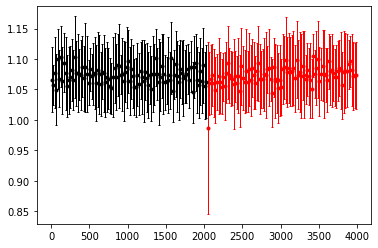

In [252]:
left_beta_cal0 = left_beta - left_time*args_l[0]
offset = left_beta_cal0.mean()-right_beta.mean()
left_beta_cal = left_beta_cal0 - offset

plt.errorbar(right_time,right_beta,xerr=0,yerr=np.array(std)[time_plot>jump_time],fmt='.r',elinewidth=1,capthick=1,capsize=1,label='Binned Data')
plt.errorbar(left_time,left_beta_cal,xerr=0,yerr=np.array(std)[time_plot<=jump_time],fmt='.k',elinewidth=1,capthick=1,capsize=1,label='Binned Data')

In [253]:
beta_cal = np.concatenate((left_beta_cal,right_beta),axis=0)
time_cal = np.concatenate((left_time,right_time),axis=0)
std_cal = np.concatenate((np.array(std)[time_plot<=jump_time],np.array(std)[time_plot>jump_time]),axis=0)

<ErrorbarContainer object of 3 artists>

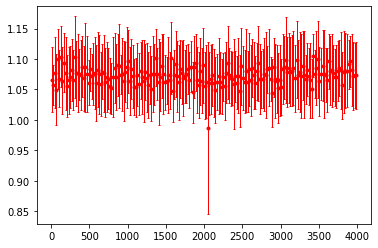

In [254]:
plt.errorbar(time_cal,beta_cal,xerr=0,yerr=std_cal,fmt='.r',elinewidth=1,capthick=1,capsize=1,label='Binned Data')

In [255]:
find_jump2 = []

for i in range(len(beta_init)-1):
    find_jump2.append(beta_init[i+1]-beta_init[i])
    
jump2 = np.where(find_jump2 == np.max(find_jump2))[0]
jump_time2 = np.array(time)[jump2]

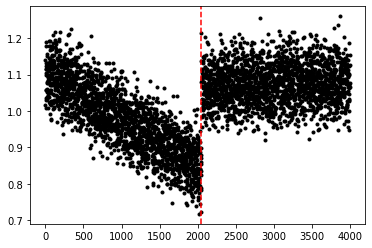

In [256]:
plt.plot(time,beta_init,marker='.',linestyle='',color='k')
plt.axvline(jump_time2,linestyle='--',color='red')

In [257]:
left_beta2  = np.array(beta_init)[time<=jump_time2]
right_beta2 = np.array(beta_init)[time>jump_time2]
left_time2  = np.array(time)[time<=jump_time2]
right_time2 = np.array(time)[time>jump_time2]

In [258]:
left_beta_cal0 = left_beta2 - left_time2*args_l[0]
offset = left_beta_cal0.mean()-right_beta2.mean()
left_beta_cal = left_beta_cal0 - offset

beta_cal = np.concatenate((left_beta_cal,right_beta2),axis=0)
time_cal = np.concatenate((left_time2,right_time2),axis=0)

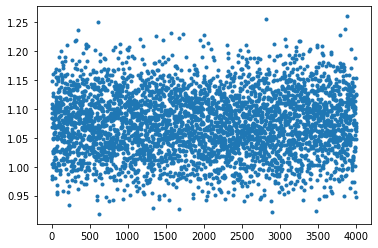

In [259]:
plt.plot(time_cal,beta_cal,'.')

In [260]:
beta_plot,time_plot,std = binning(time_cal,beta_cal,100)

<ErrorbarContainer object of 3 artists>

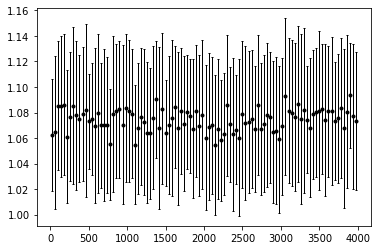

In [261]:
plt.errorbar(time_plot,beta_plot,xerr=0,yerr=std,fmt='.k',elinewidth=1,capthick=1,capsize=1,label='Binned Data')

Text(0.5, 1.0, 'Distribution of Calibrated $\\beta_{\\rm init}$ Values')

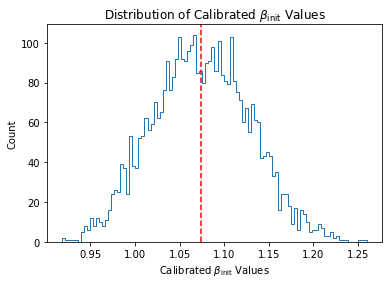

In [262]:
plt.hist(beta_cal,bins=100,histtype='step')
plt.axvline(beta_cal.mean(),linestyle='--',color='red')
plt.xlabel(r'Calibrated $\beta_{\rm init}$ Values')
plt.ylabel('Count')
plt.title(r'Distribution of Calibrated $\beta_{\rm init}$ Values')

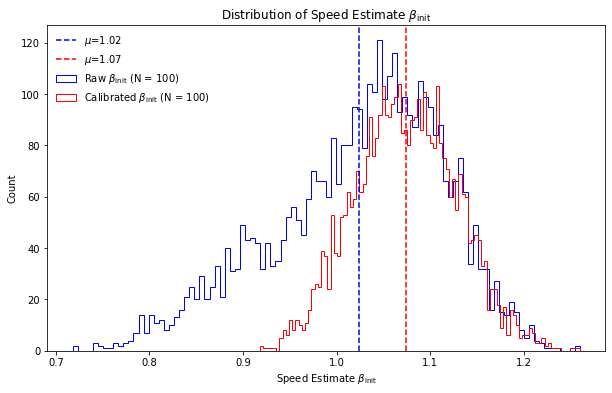

In [263]:
fig=plt.figure(figsize=(10,6))
plt.hist(beta_init,color='blue',label=r'Raw $\beta_{\rm init}$ (N = 100)',histtype='step',bins=100)
plt.axvline(beta_init.mean(),linestyle='--',color='blue',label=fr'$\mu$={np.round(beta_init.mean(),2)}')
plt.hist(beta_cal,color='red',label=r'Calibrated $\beta_{\rm init}$ (N = 100)',histtype='step',bins=100)
plt.axvline(beta_cal.mean(),linestyle='--',color='red',label=fr'$\mu$={np.round(beta_cal.mean(),2)}')
plt.legend(frameon=False)
plt.title(r'Distribution of Speed Estimate $\beta_{\rm init}$')
plt.ylabel('Count')
plt.xlabel(r'Speed Estimate $\beta_{\rm init}$')
fig.savefig('{0}/{1}.pdf'.format(figpath,'opg_5_2_D_f'), bbox_inches="tight")

In [264]:
beta_cal.std(ddof=1)

0.05442115312942585

#### E) Using all information available, what is the best calibration of $\beta$ you can produce?

Move mean to 1 as all particles should move with this speed

In [265]:
offset2 = beta_cal.mean()-1
beta_cal2 = beta_cal-offset2

Text(0.5, 1.0, 'Distribution of Calibrated $\\beta_{\\rm init}$ Values')

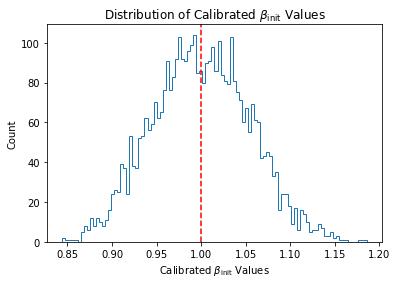

In [266]:
plt.hist(beta_cal2,bins=100,histtype='step')
plt.axvline(beta_cal2.mean(),linestyle='--',color='red')
plt.xlabel(r'Calibrated $\beta_{\rm init}$ Values')
plt.ylabel('Count')
plt.title(r'Distribution of Calibrated $\beta_{\rm init}$ Values')

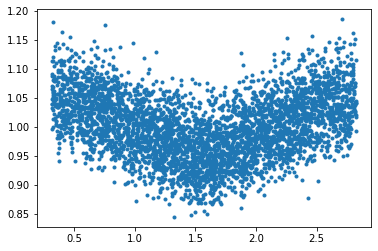

In [267]:
plt.plot(theta,beta_cal2,'.')

In [268]:
def cos(x,a,b,c,d):
    return a*np.cos(b*x+c)+d

In [269]:
beta_plot,theta_plot,std = binning(theta,beta_cal2,100)

In [270]:
popt, pcov = curve_fit(cos, xdata=theta_plot, ydata=beta_plot, sigma=None)
perr = np.sqrt(np.diag(pcov))

In [271]:
chi2_object = Chi2Regression(cos, theta_plot, beta_plot, std)
minuit = Minuit(chi2_object, print_level=0, pedantic=False, a=popt[0],b=popt[1],c=popt[2],d=popt[3])
minuit.migrad(); 

if (not minuit.fmin.is_valid) :
    print("  WARNING: The ChiSquare fit DID NOT converge!!! ")
    
for name in minuit.parameters:
    print("Fit value: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit.values[name], minuit.errors[name]))
    
chi2_val_fit = minuit.fval
print('Chi2 value of fit:',chi2_val_fit)
Ndata = len(theta_plot)
N_DOF = Ndata - len(minuit.args)
print('Degrees of freedom: ',N_DOF)
chi2_prob =  stats.chi2.sf(chi2_val_fit, N_DOF)
print('Chi2 probability',chi2_prob)

d = {'Entries':  Ndata,
     'Chi2':     chi2_val_fit,
     'ndf':      N_DOF,
     'Prob':     chi2_prob,
    }

for name in minuit.parameters:
    d[name] = [minuit.values[name], minuit.errors[name]]
    
d_cos = d
chi2_prob_cos = chi2_prob
chi2_val_cos = chi2_val_fit
args_theta = minuit.args

Fit value: a = 0.04537 +/- 0.00794
Fit value: b = 2.41662 +/- 0.48880
Fit value: c = -0.65156 +/- 0.77153
Fit value: d = 1.00485 +/- 0.01036
Chi2 value of fit: 3.3702677723918444
Degrees of freedom:  97
Chi2 probability 1.0


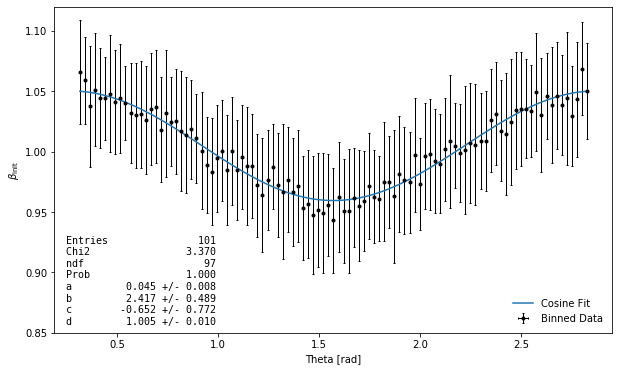

In [272]:
fig,axes = plt.subplots(nrows=1,ncols=1,figsize=(10,6))

axes.errorbar(theta_plot,beta_plot,xerr=0,yerr=std,fmt='.k',elinewidth=1,capthick=1,capsize=1,label='Binned Data')
axes.plot(np.sort(theta_plot),cos(np.sort(theta_plot),*args_theta),linestyle='-',label='Cosine Fit')
text = nice_string_output(d_cos, extra_spacing=2, decimals=3);
add_text_to_ax(0.02, 0.3, text, axes, fontsize=10);
axes.set_ylim(0.85,1.12)
axes.set_xlabel('Theta [rad]')
axes.set_ylabel(r'$\beta_{\rm init}$')
axes.legend(frameon=False,loc='lower right')
fig.savefig('{0}/{1}.pdf'.format(figpath,'opg_5_2_E'), bbox_inches="tight")

In [273]:
beta_cal3 = beta_cal2+cos(theta,-args_theta[0],args_theta[1],args_theta[2],0)

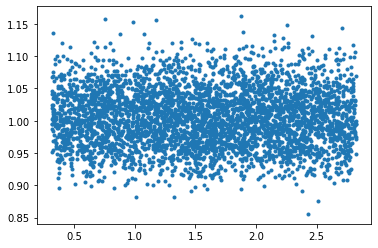

In [274]:
plt.plot(theta,beta_cal3,'.')

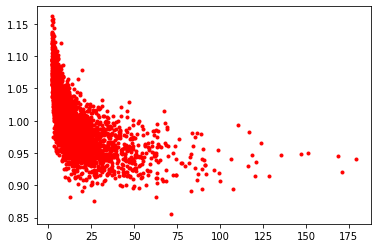

In [275]:
plt.plot(energy,beta_cal3,'.',color='red')

In [276]:
def exponential(x,a,b,c):
    return np.exp(a*x)*b+c

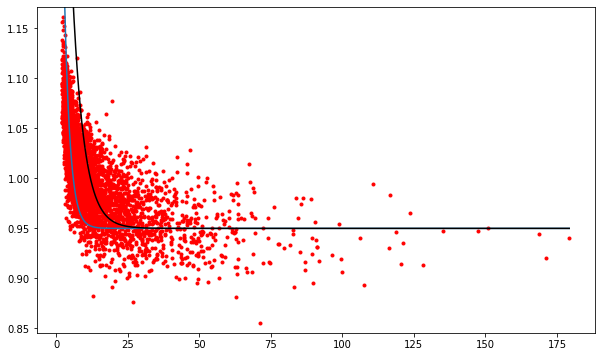

In [277]:
fig=plt.figure(figsize=(10,6))
plt.plot(energy,beta_cal3,'.',color='red')
xes=np.linspace(energy.min(),energy.max(),1000)
plt.ylim(beta_cal3.min()-0.01,beta_cal3.max()+0.01)
plt.plot(xes,exponential(xes,-0.5,1,0.95))
plt.plot(xes,exponential(xes,-0.25,1,0.95),color='k')

In [278]:
beta_plot,energy_plot,std = binning(energy,beta_cal3,100)

In [279]:
popt, pcov = curve_fit(exponential, xdata=energy_plot, ydata=beta_plot, sigma=None)
perr = np.sqrt(np.diag(pcov))

In [284]:
chi2_object = Chi2Regression(exponential, energy_plot, beta_plot,std)
minuit = Minuit(chi2_object, print_level=0, pedantic=False, a=-0.25,b=1,c=0.95)
#minuit = Minuit(chi2_object, print_level=0, pedantic=False, a=popt[0],b=popt[1],c=popt[2])
minuit.migrad(); 

if (not minuit.fmin.is_valid) :
    print("  WARNING: The ChiSquare fit DID NOT converge!!! ")
    
for name in minuit.parameters:
    print("Fit value: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit.values[name], minuit.errors[name]))
    
chi2_val_fit = minuit.fval
print('Chi2 value of fit:',chi2_val_fit)
Ndata = len(energy_plot)
N_DOF = Ndata - len(minuit.args)
print('Degrees of freedom: ',N_DOF)
chi2_prob =  stats.chi2.sf(chi2_val_fit, N_DOF)
print('Chi2 probability',chi2_prob)

d = {'Entries':  Ndata,
     'Chi2':     chi2_val_fit,
     'ndf':      N_DOF,
     'Prob':     chi2_prob,
    }

for name in minuit.parameters:
    d[name] = [minuit.values[name], minuit.errors[name]]
    
d_e = d
chi2_prob_e = chi2_prob
chi2_val_e = chi2_val_fit
args_e = minuit.args

Fit value: a = -0.10960 +/- 0.04385
Fit value: b = 0.14702 +/- 0.04126
Fit value: c = 0.95211 +/- 0.00668
Chi2 value of fit: 3.1805164485593016
Degrees of freedom:  32
Chi2 probability 0.9999999999820268


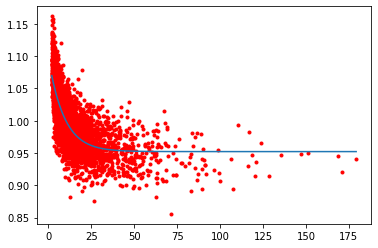

In [285]:
plt.plot(energy,beta_cal3,'.',color='red')
plt.plot(np.sort(energy),exponential(np.sort(energy),*args_e),linestyle='-')

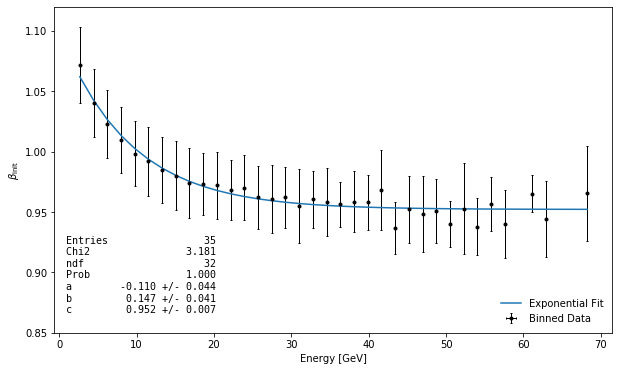

In [296]:
fig,axes = plt.subplots(nrows=1,ncols=1,figsize=(10,6))

axes.errorbar(energy_plot,beta_plot,xerr=0,yerr=std,fmt='.k',elinewidth=1,capthick=1,capsize=1,label='Binned Data')
axes.plot(np.sort(energy_plot),exponential(np.sort(energy_plot),*args_e),linestyle='-',label='Exponential Fit')
text = nice_string_output(d_e, extra_spacing=2, decimals=3);
add_text_to_ax(0.02, 0.3, text, axes, fontsize=10);
axes.set_ylim(0.85,1.12)
axes.set_xlabel('Energy [GeV]')
axes.set_ylabel(r'$\beta_{\rm init}$')
axes.legend(frameon=False,loc='lower right')
fig.savefig('{0}/{1}.pdf'.format(figpath,'opg_5_2_E_exp'), bbox_inches="tight")

In [288]:
beta_cal4 = beta_cal3 - exponential(energy,args_e[0],args_e[1],0)

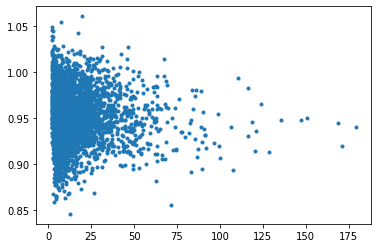

In [289]:
plt.plot(energy,beta_cal4,'.')

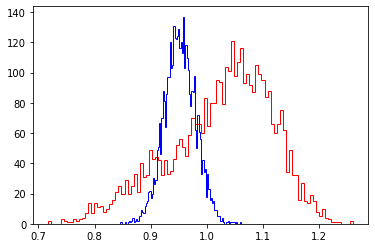

In [290]:
plt.hist(beta_init,bins=100,histtype='step',color='red');
plt.hist(beta_cal4,bins=100,histtype='step',color='blue');

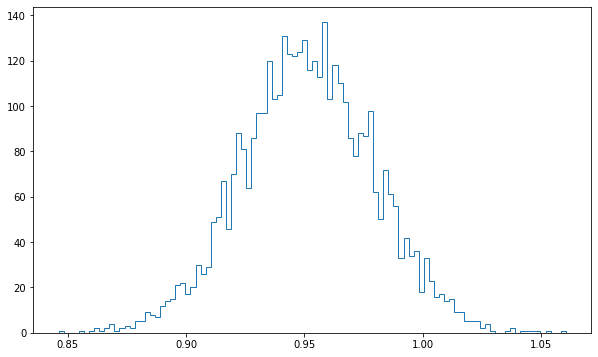

In [291]:
fig2, ax2 = plt.subplots(figsize=(10,6));
counts, bin_edges, _ = ax2.hist(beta_cal4, 100, range=(beta_cal4.min(), beta_cal4.max()), histtype='step',label='Binned Data (N=100)');
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
s_counts = np.sqrt(counts)


In [292]:
mean = beta_cal4.mean()
sigma = beta_cal4.std(ddof=1)
chi2_object = Chi2Regression(gaussian, bin_centers, counts)
minuit = Minuit(chi2_object, print_level=0, pedantic=False, N=22,mu=mean,sigma=sigma)
minuit.migrad(); 

if (not minuit.fmin.is_valid) :
    print("  WARNING: The ChiSquare fit DID NOT converge!!! ")
    
for name in minuit.parameters:
    print("Fit value: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit.values[name], minuit.errors[name]))
    
chi2_val_fit = minuit.fval
print('Chi2 value of fit:',chi2_val_fit)
Ndata = len(bin_centers)
N_DOF = Ndata - len(minuit.args)
print('Degrees of freedom: ',N_DOF)
chi2_prob =  stats.chi2.sf(chi2_val_fit, N_DOF)
print('Chi2 probability',chi2_prob)

d = {'Entries':  Ndata,
     'Chi2':     chi2_val_fit,
     'ndf':      N_DOF,
     'Prob':     chi2_prob,
     'N':        minuit.values['N']+-minuit.errors['N'],
     'mu':       minuit.values['mu']+-minuit.errors['mu'],
     'sigma':    minuit.values['sigma']+-minuit.errors['sigma']
    }

for name in minuit.parameters:
    d[name] = [minuit.values[name], minuit.errors[name]]
    
d_gauss = d
chi2_prob_gauss = chi2_prob
chi2_val_gauss = chi2_val_fit
args_gauss = minuit.args

Fit value: N = 8.55606 +/- 0.01778
Fit value: mu = 0.95109 +/- 0.00007
Fit value: sigma = 0.02764 +/- 0.00007
Chi2 value of fit: 4497.935321967369
Degrees of freedom:  97
Chi2 probability 0.0


In [293]:
text = nice_string_output(d_gauss, extra_spacing=2, decimals=3);
add_text_to_ax(0.02, 0.95, text, ax2, fontsize=12);

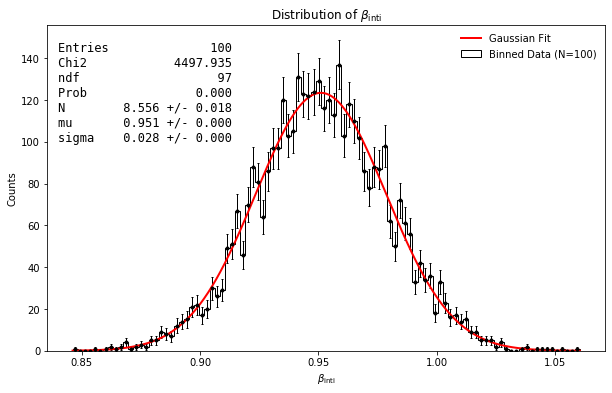

In [295]:
fig2, ax2 = plt.subplots(figsize=(10,6));
counts, bin_edges, _ = ax2.hist(beta_cal4, 100, range=(beta_cal4.min(), beta_cal4.max()), histtype='step',label='Binned Data (N=100)',color='k');
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
s_counts = np.sqrt(counts)

ax2.errorbar(bin_centers,counts,xerr=0,yerr=s_counts,fmt='.k',elinewidth=1,capthick=1,capsize=1)

xrange=np.linspace(bin_edges.min(),bin_edges.max(),1000)
text = nice_string_output(d_gauss, extra_spacing=2, decimals=3);
add_text_to_ax(0.02, 0.95, text, ax2, fontsize=12);
ax2.plot(xrange,gaussian(xrange,*args_gauss),linestyle='-',label='Gaussian Fit',color='r',linewidth=2)
ax2.legend(frameon=False)
ax2.set_xlabel(r'$\beta_{\rm inti}$')
ax2.set_ylabel('Counts')
plt.title(r'Distribution of $\beta_{\rm inti}$')
fig2
fig2.savefig('{0}/{1}.pdf'.format(figpath,'opg_5_2_E_final'), bbox_inches="tight")